In [303]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from itertools import product, compress
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
%load_ext tensorboard
matplotlib.rcParams.update({'font.size': 24})
plt.style.use("ggplot")

PATH_DATA = "../datasets/SARS2/"
PATH_DATA_GHDDI = "../datasets/SAR1/GHDDI"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
def get_features_morgan(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = {}
    fps = {}
    mol_names = set()
    error_mols = 0
    for mol in structures_shared:
        if mol is None:
            error_mols += 1
            continue
        if mol.GetProp("_Name") in mol_names:
            continue
        name = int(mol.GetProp("_Name"))
        mol_names.add(name)
        key = Chem.inchi.MolToInchiKey(mol)
        if (name, key) not in features:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
            fps[(name, key)] = fp
            arr = np.zeros((0,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp,arr)
            features[(name, key)] = arr
    print(f"Found problems in {error_mols} molecules")
    return fps, features, mol_names

def get_molecules_from_data(features, fps, data, id_column="Molecule_ID", structure_column="Standardized_Molecule_InChIKey", smiles_columns="Standardized_Molecule_Smiles", only_exact_matches=True, threshold_similarity=0.99):
    mol_ids = data[id_column]
    keys = data[structure_column]
    filtered_features = []
    filtered_fps = []
    mask = []
    unfound_structures = Chem.SDWriter(os.path.join(PATH_DATA, "molecules_missing.sdf"))
    for id_val in zip(mol_ids, keys):
        if id_val in features:
            mask.append(True)
            filtered_features.append(features[id_val])
            filtered_fps.append(fps[id_val])
        else:
            similar_mols = [k for k in features if k[0] == id_val[0]]
            if not similar_mols:
                print("Could not find molecules with id", id_val[0])
                mask.append(False)
                continue
            if only_exact_matches:
                mask.append(False)
                print(id_val)
                print(similar_mols)
            else:
                fps_similars = [fps[k] for k in similar_mols]
                smiles = data[(data[id_column] == id_val[0]) & (data[structure_column] == id_val[1])][smiles_columns].values[0]
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    if len(similar_mols) == 1:
                        mask.append(True)
                        filtered_features.append(features[similar_mols[0]])
                        filtered_fps.append(fps[similar_mols[0]])
                        continue
                    else:
                        mask.append(False)
                        print("Could not create molecule", id_val, "with smiles", smiles, "most similar", similar_mols)
                        continue
                mol.SetProp("_Name", str(id_val[0]))
                fp_mol = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
                similarities = [DataStructs.TanimotoSimilarity(fp_mol, fp_possible) for fp_possible in fps_similars]
                # print(id_val)
                # print("Most similar molecules:")
                # for ids, sim in zip(similar_mols, similarities):
                    # print("\t", ids, sim)
                most_similar = np.argmax(similarities)
                if similarities[most_similar] > threshold_similarity:
                    # print("Selected: ", similar_mols[most_similar], similarities[most_similar])
                    mask.append(True)
                    filtered_features.append(features[similar_mols[most_similar]])
                    filtered_fps.append(fps[similar_mols[most_similar]])
                else:
                    unfound_structures.write(mol)
                    print(id_val)
                    for ids, sim in zip(similar_mols, similarities):
                        print("\t", ids, sim)
                    mask.append(False)
    return np.array(filtered_features), filtered_fps, mask

def convert_IC50_to_um(data, col_values, col_units):
    new_vals = []
    for val, unit in zip(data[col_values], data[col_units]):
        if unit == "nM":
            new_vals.append(val/1000)
        elif unit == "µM":
            new_vals.append(val)
        else:
            raise ValueError(f"{unit} unit not found!")
    data[col_values] = new_vals
    data[col_units] = "µM"
    return data

def filter_duplicates(data, col_id, col_structure):
    dup = data.duplicated(subset=[col_id, col_structure], keep=False)
    to_remove = []
    for id_val in data[dup][col_id].unique():
        dup_data = data[data[col_id] == id_val]
        if len(set(dup_data["Is_active"])) != 1:
            to_remove.append(id_val)
    rm_masks = data[col_id].isin(to_remove)
    data = data[~rm_masks]
    return data, rm_masks

In [4]:
fps_morgan, features_morgan, names_morgan = get_features_morgan(os.path.join(PATH_DATA, "SIM_Broad_MProResults_ligprep_maestro.sd"))

RDKit WARNING: [16:22:17] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [16:22:17] Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [16:22:17] ERROR: Could not sanitize molecule ending on line 15167
RDKit ERROR: [16:22:17] ERROR: Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [16:22:17] Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [16:22:17] ERROR: Could not sanitize molecule ending on line 15269
RDKit ERROR: [16:22:17] ERROR: Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [16:22:17] Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [16:22:17] ERROR: Could not sanitize molecule ending on line 15371
RDKit ERROR: [16:22:17] ERROR: Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [16:22:17] Explicit valence for atom # 1 C greater than permitted
RDKit ERROR: [16:22:17] ERROR: Could not sanitize molecule ending on line 15473
RDKit ERROR: [16:22

Found problems in 8 molecules


In [5]:
threshold_activity = 20 # uM
data_orig_broad = pd.read_csv(os.path.join(PATH_DATA, "20200623_3CLpro_Hits_Broad_DOMPE_Summary-broad.csv"), decimal=",")
data_orig_dompe = pd.read_csv(os.path.join(PATH_DATA, "20200623_3CLpro_Hits_Broad_DOMPE_Summary-dompe.csv"), decimal=",")
data_orig_broad = data_orig_broad.rename(columns={"NAME": "Name",
                                                  "3CL-Pro IC50-15min (µM) (triplicates)": "IC50 µM 15 min",
                                                  "3CLpro\n IC50 slope (µM) (triplicates)": "IC50 µM slope"})
data_orig_dompe = data_orig_dompe.rename(columns={"IC50 µM\n 15 min\n (red manually confirmed)": "IC50 µM 15 min",
                                                  "IC50 µM\n slope\n (red manually confirmed)": "IC50 µM slope"})
data_full = pd.concat([data_orig_broad, data_orig_dompe])

correspondance_broad = pd.read_csv(os.path.join(PATH_DATA, "DOMPE_Broad_MProResults_IDCorrespondence_broad.csv"), decimal=",")
correspondance_broad = correspondance_broad.rename(columns={"Molecule_id": "Molecule_ID"})
correspondance_dompe = pd.read_csv(os.path.join(PATH_DATA, "DOMPE_Broad_MProResults_IDCorrespondence_dompe.csv"), decimal=",")
correspondance = pd.concat([correspondance_broad, correspondance_dompe])
correspondance = correspondance.rename(columns={"Fraunofer Compound Id": "Compound Id"})
data_full = data_full.merge(correspondance, how="inner", on="Compound Id")

In [6]:
data_full["Is_active"] = (data_full["IC50 µM 15 min"] < threshold_activity).values.astype(int)
print(data_full.shape)

(191, 32)


In [7]:
dup = data_full.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep="first")
print(f"Found {sum(dup)} duplicated entries")
all_dup = data_full.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep=False)
data_full = data_full[~dup]
print(data_full.shape)

Found 10 duplicatd entries
(181, 32)


In [8]:
data_full[all_dup]

<ipython-input-8-a1eea94c62b9>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_full[all_dup]


,Compound Id,Name,DTT sensitivity (if > 30 % loss of activity at 20 µM),Inhibition [%] Primary Screen (single point; 20 µM),"HC\nInhibition [%] (triplicate, 20 µM)","HC\n AV Inhibition [%] (triplicate, 20 µM)\nslope",AV inhibition +DTT 15min \nduplicates,IC50 µM 15 min,IC50 µM slope,%inhibition_d03-KU_LW,...,AV Inhibiton\n 15min,%Inhibition\n_slope PS,%Inhibition\n_15min PS,VeroE6% \nConfluence_d03,VeroE6 % \nInhibition_d03,Chemically reactive?,Molecule_ID,Standardized_Molecule_InChIKey,Standardized_Molecule_Smiles,Is_active
8,SPE_K81330143,Tideglusib,sensitiv,90.94,99.30,99.28,-4.89,0.15,0.14,-3.46,...,NaN,NaN,NaN,NaN,NaN,NaN,3878,PMJIHLSCWIDGMD-UHFFFAOYSA-N,O=C1SN(C(=O)N1Cc2ccccc2)c3cccc4ccccc34,1
9,SPE_K34149328,bonaphthone,sensitiv,95.47,99.37,100.31,37.44,0.16,0.38,-1.01,...,NaN,NaN,NaN,NaN,NaN,NaN,4448,MXWZRRPNVLCHMY-UHFFFAOYSA-N,Brc1ccc2C(=O)C(=O)C=Cc2c1,1
30,SPE_K86972824,OLTIPRAZ,sensitiv,93.83,97.56,101.75,1.56,0.62,1.44,6.11,...,NaN,NaN,NaN,NaN,NaN,NaN,8437,CKNAQFVBEHDJQV-UHFFFAOYSA-N,CC1=C(SSC1=S)c2cnccn2,1
33,SPE_K55591206,(-)-Epigallocatechin Gallate,sensitiv,95.26,98.89,97.04,-22.36,0.72,1.29,-1.41,...,NaN,NaN,NaN,NaN,NaN,NaN,522,WMBWREPUVVBILR-WIYYLYMNSA-N,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@H...,1
38,SPE_K68408467,PROFLAVINE HEMISULFATE,sensitiv,60.89,76.55,99.87,20.41,0.83,2.02,19.09,...,NaN,NaN,NaN,NaN,NaN,NaN,6835,WDVSHHCDHLJJJR-UHFFFAOYSA-N,Nc1ccc2cc3ccc(N)cc3nc2c1,1
58,SPE_M87138257,Acriflavine hydrochloride,Acriflavine hydrochloride,59.00,67.97,99.10,68.22,1.93,5.10,-26.74,...,NaN,NaN,NaN,NaN,NaN,NaN,6864,NLROCEWTIPMDKX-UHFFFAOYSA-N,C[N]1=C2C=C(N)C=CC2=Cc3ccc(N)cc13,1
74,SPE_K20313525,rosmarinic-acid,sensitiv,95.67,94.92,94.14,-17.76,3.86,4.96,8.26,...,NaN,NaN,NaN,NaN,NaN,NaN,8605,DOUMFZQKYFQNTF-WUTVXBCWSA-N,OC(=O)[C@@H](Cc1ccc(O)c(O)c1)OC(=O)\C=C\c2ccc(...,1
95,SPE_A49172652,LANSOPRAZOLE,sensitiv,97.15,98.57,96.07,-12.10,7.25,10.83,1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,348,MJIHNNLFOKEZEW-UHFFFAOYSA-N,Cc1c(OCC(F)(F)F)ccnc1CS(=O)c2nc3ccccc3[nH]2,1
112,SPE_K76841105,Tazarotene (Avage),Tazarotene (Avage),-880.10,-692.49,108.07,-663.39,13.50,321.75,-2.40,...,NaN,NaN,NaN,NaN,NaN,NaN,445,OGQICQVSFDPSEI-UHFFFAOYSA-N,CCOC(=O)c1ccc(nc1)C#Cc2ccc3SCCC(C)(C)c3c2,1
137,SPE_K33623053,Rose Bengal Sodium Salt,Rose Bengal Sodium Salt,99.60,74.85,-2.27,69.98,1176.55,26.97,22.43,...,NaN,NaN,NaN,NaN,NaN,NaN,5272,IICCLYANAQEHCI-UHFFFAOYSA-N,Oc1c(I)cc2c(Oc3c(I)c(O)c(I)cc3C24OC(=O)c5c(Cl)...,0


In [154]:
features_full, fps_full, mask = get_molecules_from_data(features_morgan, fps_morgan, data_full, only_exact_matches=False, threshold_similarity=0.2)
data_filtered = data_full[mask]
active_SARS2 = data_filtered["Is_active"].values
print(sum(mask))

Could not find molecules with id 11947
Could not find molecules with id 12210
Could not find molecules with id 10107
Could not find molecules with id 7168
Could not find molecules with id 11215
Could not find molecules with id 10484
Could not find molecules with id 10913
Could not find molecules with id 12105
Could not find molecules with id 11495
Could not find molecules with id 6326
Could not find molecules with id 10781
Could not find molecules with id 11917
Could not find molecules with id 10766
Could not find molecules with id 12364
(10817, 'PSFDQSOCUJVVGF-UHFFFAOYSA-N')
	 (10817, 'FLJHILGVZZUAHY-UHFFFAOYSA-N') 0.11764705882352941
166


RDKit ERROR: [14:40:39] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [14:40:39] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [14:40:39] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [14:40:39] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [14:40:39] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [14:40:39] Explicit valence for atom # 3 N, 4, is greater than permitted


Load GHDDI data set

In [10]:
data_GHDDI_orig = pd.read_csv(os.path.join(PATH_DATA_GHDDI, "3CLProtease_ActiveDataset.csv"), decimal=",")
activity_col = "value_GHDDI"
measures_col = "parameter_GHDDI"
units_col = "unit_GHDDI"
id_col = "Molecule_ID"

In [172]:
data_GHDDI = data_GHDDI_orig.dropna(subset=[activity_col, id_col]).copy()
data_GHDDI[id_col] = data_GHDDI[id_col].astype(int)
data_GHDDI = data_GHDDI[data_GHDDI[measures_col] == "IC50"]
dup = data_GHDDI.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep="first")
print(f"Found {sum(dup)} duplicated entries")
data_GHDDI = data_GHDDI[~dup]
data_GHDDI.shape

Found 0 duplicated entries


(401, 33)

Convert all experimental values to micromolar

In [173]:
data_GHDDI = convert_IC50_to_um(data_GHDDI, activity_col, units_col)
data_GHDDI["Is_active"] = (data_GHDDI[activity_col] < threshold_activity).values.astype(int)

In [174]:
fps_morgan_GHDDI, features_morgan_GHDDI, names_morgan_GHDDI = get_features_morgan(os.path.join(PATH_DATA_GHDDI, "3C-like_protease_GHDDI_ligprep_maestro.sdf"))

RDKit WARNING: [14:50:39] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [14:50:39] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [14:50:39] ERROR: Could not sanitize molecule ending on line 11557
RDKit WARNING: [14:50:39] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [14:50:39] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [14:50:40] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [14:50:40] ERROR: Could not sanitize molecule ending on line 85833
RDKit ERROR: [14:50:40] ERROR: Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [14:50:40] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [14:50:40] ERROR: Could not sanitize molecule ending on line 86055
RDKit ERROR: [14:50:40] ERROR: Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [14:50:40] Explicit valence for atom

Found problems in 8 molecules


RDKit WARNING: [14:50:40] Warning: molecule is tagged as 3D, but all Z coords are zero


In [175]:
features_GHDDI, fps_GHDDI, mask_GHDDI = get_molecules_from_data(features_morgan_GHDDI, fps_morgan_GHDDI, data_GHDDI, only_exact_matches=False, threshold_similarity=0.2)
data_GHDDI = data_GHDDI[mask_GHDDI]
active_SARS1 = data_GHDDI["Is_active"].values
print(data_GHDDI.shape, sum(mask_GHDDI))

RDKit ERROR: [14:50:40] ERROR: Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [14:50:40] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [14:50:40] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [14:50:40] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [14:50:40] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [14:50:40] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [14:50:40] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [14:50:40] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [14:50:40] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [14:50:40] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [14:50:40] Explicit valence for atom # 9 N, 4, is greater than permitted


Could not find molecules with id 9602
Could not create molecule (13731, 'UQVSUXRMZASXNN-XKJQSASLSA-N') with smiles CCN1\C(=C\C=C\C2=C\C(=C\C3=[N](CC)c4ccccc4S3)\CC(C)C2)\Sc5ccccc15 most similar [(13731, 'KZXIOTHRXJTPFX-WCBOMGOGSA-N'), (13731, 'KZXIOTHRXJTPFX-FVUJIRFESA-N')]
Could not create molecule (13740, 'UQVSUXRMZASXNN-FZLDUNQWSA-N') with smiles CCN1\C(=C/C=C/C2=C\C(=C\C3=[N](CC)c4ccccc4S3)\CC(C)C2)\Sc5ccccc15 most similar [(13740, 'KZXIOTHRXJTPFX-WCBOMGOGSA-N'), (13740, 'KZXIOTHRXJTPFX-FVUJIRFESA-N')]
(398, 34) 398


In [30]:
joined_sets = pd.concat([data_filtered, data_GHDDI], ignore_index=True)
joined_features = np.vstack((features_full, features_GHDDI))
joined_fps = fps_full+fps_GHDDI
joined_sets, mask_to_rm = filter_duplicates(joined_sets, id_col, "Standardized_Molecule_InChIKey")
joined_features = joined_features[~mask_to_rm]
joined_fps = list(compress(joined_fps, ~mask_to_rm))
active = joined_sets["Is_active"].values
print(joined_sets.shape)

(562, 62)


Actives 309, 54.98%; Inactives 253, 45.02%


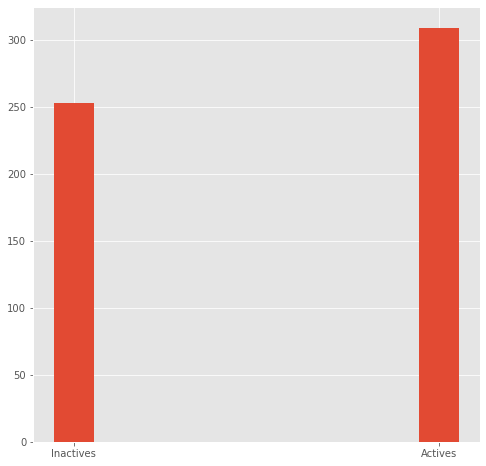

In [16]:
plt.figure(figsize=(8,8))
plt.hist(active, bins=10);
plt.xticks([0.05, 0.95], ["Inactives", "Actives"])
n_active = sum(active)
n_inactive = len(active)-n_active
print(f"Actives {n_active}, {100*n_active/(n_active+n_inactive):.2f}%; Inactives {n_inactive}, {100*n_inactive/(n_active+n_inactive):.2f}%")

In [80]:
def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly classified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return [accuracy, mcc]

def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    f, ax = plt.subplots(1, 1)
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    plt.show()
    
def grid_search_SVM(train_data, test_data, train_labels, test_labels, max_gamma=1, min_gamma=0.001, max_C=100, min_C=0.01, n_points=30):
    accuracy = []
    MCCs = []
    C_values = np.geomspace(min_C, max_C, num=n_points)
    gamma_values = np.geomspace(min_gamma, max_gamma, num=n_points)
    for c_val in C_values:
        acc = []
        mcc = []
        for gamma in gamma_values:
            svm = SVC(C=c_val, kernel="rbf", gamma=gamma)
            svm.fit(train_data, train_labels)
            predictions = svm.predict(test_data)
            print(f"C={c_val}, gamma={gamma}")
            vals = print_metrics(predictions, test_labels)
            acc.append(vals[0])
            mcc.append(vals[1])
        accuracy.append(acc)
        MCCs.append(mcc)

    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(MCCs, annot=False, ax = ax, cmap="Greens")
    ax.set_yticklabels(np.round(C_values, 2), rotation=0)
    ax.set_xticklabels(np.round(gamma_values, 2), rotation=90)
    ax.set_ylabel("C value")
    ax.set_xlabel(r"$\gamma$")
    plt.show()

In [18]:
train_data, test_data, train_labels, test_labels = train_test_split(joined_features, active, test_size=0.25, random_state=42, stratify=active)

C=0.01, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.01373823795883263
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.017433288221999882
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.022122162910704492
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.02807216203941177
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.035622478902624426
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.04520353656360243
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.057361525104486784
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.0727895384398315
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.09236708571873861
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=1.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.01373823795883263
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.017433288221999882
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.022122162910704492
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.02807216203941177
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.035622478902624426
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.04520353656360243
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.057361525104486784
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.0727895384398315
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.09236708571873861
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=1.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.01373823795883263
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.017433288221999882
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.022122162910704492
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.02807216203941177
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.035622478902624426
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.04520353656360243
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.057361525104486784
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.0727895384398315
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.09236708571873861
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=1.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.01373823795883263
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.017433288221999882
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.022122162910704492
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.02807216203941177
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.035622478902624426
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.04520353656360243
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.057361525104486784
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.0727895384398315
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.09236708571873861
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=1.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.01373823795883263
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.017433288221999882
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.022122162910704492
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.02807216203941177
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.035622478902624426
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.04520353656360243
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.057361525104486784
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.0727895384398315
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.09236708571873861
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=1.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.01373823795883263
NER: 0.508, Sensitivity or recall: 1.000, Specificity: 0.016, Precision: 0.557, Correctly classified: 0.560, MCC: 0.094
C=0.04893900918477494, gamma=0.017433288221999882
NER: 0.587, Sensitivity or recall: 1.000, Specificity: 0.175, Precision: 0.600, Correctly classified: 0.631, MCC: 0.324
C=0.04893900918477494, gamma=0.022122162910704492
NER: 0.595, Sensitivity or recall: 1.000, Specificity: 0.190, Precision: 0.605, Correctly classified: 0.638, MCC: 0.339
C=0.04893900918477494, gamma=0.02807216203941177
NER: 0.595, Sensitivity or recall: 1.000, Specificity: 0.190, Precision: 0.605, Correctly classified: 0.638, MCC: 0.339
C=0.04893900918477494, gamma=0.035622478902624426
NER: 0.587, Sensitivity or recall: 1.000, Specificity: 0.175, Precision: 0.600, Correctly classified: 0.631, MCC: 0.324
C=0.04893900918477494, gamma=0.04520353656360243
NER: 0.508, Sensitivity or recall: 1.000, Specificity: 0.016, Precision: 0.557, Correctly classified: 0

<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.0727895384398315
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.09236708571873861
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=1.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.008531678524172805
NER: 0.587, Sensitivity or recall: 1.000, Specificity: 0.175, Precision: 0.600, Correctly classified: 0.631, MCC: 0.324
C=0.06723357536499334, gamma=0.010826367338740546
NER: 0.611, Sensitivity or recall: 1.000, Specificity: 0.222, Precision: 0.614, Correctly classified: 0.652, MCC: 0.369
C=0.06723357536499334, gamma=0.01373823795883263
NER: 0.611, Sensitivity or recall: 1.000, Specificity: 0.222, Precision: 0.614, Correctly classified: 0.652, MCC: 0.369
C=0.06723357536499334, gamma=0.017433288221999882
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.06723357536499334, gamma=0.022122162910704492
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.06723357536499334, gamma=0.02807216203941177
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 

<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=1.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.005298316906283708
NER: 0.579, Sensitivity or recall: 1.000, Specificity: 0.159, Precision: 0.595, Correctly classified: 0.624, MCC: 0.307
C=0.09236708571873861, gamma=0.006723357536499335
NER: 0.611, Sensitivity or recall: 1.000, Specificity: 0.222, Precision: 0.614, Correctly classified: 0.652, MCC: 0.369
C=0.09236708571873861, gamma=0.008531678524172805
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.09236708571873861, gamma=0.010826367338740546
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.09236708571873861, gamma=0.01373823795883263
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.09236708571873861, gamma=0.017433288221999882
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified:

<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=1.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.0032903445623126675
NER: 0.508, Sensitivity or recall: 1.000, Specificity: 0.016, Precision: 0.557, Correctly classified: 0.560, MCC: 0.094
C=0.12689610031679222, gamma=0.0041753189365604
NER: 0.611, Sensitivity or recall: 1.000, Specificity: 0.222, Precision: 0.614, Correctly classified: 0.652, MCC: 0.369
C=0.12689610031679222, gamma=0.005298316906283708
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.12689610031679222, gamma=0.006723357536499335
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.12689610031679222, gamma=0.008531678524172805
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.12689610031679222, gamma=0.010826367338740546
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified:

<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=1.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.002592943797404667
NER: 0.603, Sensitivity or recall: 1.000, Specificity: 0.206, Precision: 0.609, Correctly classified: 0.645, MCC: 0.355
C=0.17433288221999882, gamma=0.0032903445623126675
NER: 0.611, Sensitivity or recall: 1.000, Specificity: 0.222, Precision: 0.614, Correctly classified: 0.652, MCC: 0.369
C=0.17433288221999882, gamma=0.0041753189365604
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.17433288221999882, gamma=0.005298316906283708
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.17433288221999882, gamma=0.006723357536499335
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.17433288221999882, gamma=0.008531678524172805
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified:

<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=1.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.0016102620275609393
NER: 0.508, Sensitivity or recall: 1.000, Specificity: 0.016, Precision: 0.557, Correctly classified: 0.560, MCC: 0.094
C=0.2395026619987486, gamma=0.0020433597178569417
NER: 0.611, Sensitivity or recall: 1.000, Specificity: 0.222, Precision: 0.614, Correctly classified: 0.652, MCC: 0.369
C=0.2395026619987486, gamma=0.002592943797404667
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.2395026619987486, gamma=0.0032903445623126675
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.2395026619987486, gamma=0.0041753189365604
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.2395026619987486, gamma=0.005298316906283708
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.6

<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=1.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.32903445623126676, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.32903445623126676, gamma=0.0012689610031679222
NER: 0.595, Sensitivity or recall: 1.000, Specificity: 0.190, Precision: 0.605, Correctly classified: 0.638, MCC: 0.339
C=0.32903445623126676, gamma=0.0016102620275609393
NER: 0.611, Sensitivity or recall: 1.000, Specificity: 0.222, Precision: 0.614, Correctly classified: 0.652, MCC: 0.369
C=0.32903445623126676, gamma=0.0020433597178569417
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.32903445623126676, gamma=0.002592943797404667
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.32903445623126676, gamma=0.0032903445623126675
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.32903445623126676, gamma=0.0041753189365604
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classifi

<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.32903445623126676, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.32903445623126676, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.32903445623126676, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.32903445623126676, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.32903445623126676, gamma=1.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.553, Correctly classified: 0.553, MCC: nan


<ipython-input-25-3b0d7053d596>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.4520353656360243, gamma=0.001
NER: 0.611, Sensitivity or recall: 1.000, Specificity: 0.222, Precision: 0.614, Correctly classified: 0.652, MCC: 0.369
C=0.4520353656360243, gamma=0.0012689610031679222
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.4520353656360243, gamma=0.0016102620275609393
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.4520353656360243, gamma=0.0020433597178569417
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.4520353656360243, gamma=0.002592943797404667
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.4520353656360243, gamma=0.0032903445623126675
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.3

C=0.6210169418915616, gamma=0.09236708571873861
NER: 0.708, Sensitivity or recall: 0.987, Specificity: 0.429, Precision: 0.681, Correctly classified: 0.738, MCC: 0.518
C=0.6210169418915616, gamma=0.11721022975334805
NER: 0.652, Sensitivity or recall: 0.987, Specificity: 0.317, Precision: 0.642, Correctly classified: 0.688, MCC: 0.425
C=0.6210169418915616, gamma=0.14873521072935117
NER: 0.635, Sensitivity or recall: 1.000, Specificity: 0.270, Precision: 0.629, Correctly classified: 0.674, MCC: 0.412
C=0.6210169418915616, gamma=0.18873918221350977
NER: 0.627, Sensitivity or recall: 1.000, Specificity: 0.254, Precision: 0.624, Correctly classified: 0.667, MCC: 0.398
C=0.6210169418915616, gamma=0.2395026619987486
NER: 0.579, Sensitivity or recall: 1.000, Specificity: 0.159, Precision: 0.595, Correctly classified: 0.624, MCC: 0.307
C=0.6210169418915616, gamma=0.3039195382313198
NER: 0.579, Sensitivity or recall: 1.000, Specificity: 0.159, Precision: 0.595, Correctly classified: 0.624, MCC: 

C=1.1721022975334805, gamma=0.008531678524172805
NER: 0.728, Sensitivity or recall: 0.885, Specificity: 0.571, Precision: 0.719, Correctly classified: 0.745, MCC: 0.486
C=1.1721022975334805, gamma=0.010826367338740546
NER: 0.730, Sensitivity or recall: 0.872, Specificity: 0.587, Precision: 0.723, Correctly classified: 0.745, MCC: 0.484
C=1.1721022975334805, gamma=0.01373823795883263
NER: 0.752, Sensitivity or recall: 0.885, Specificity: 0.619, Precision: 0.742, Correctly classified: 0.766, MCC: 0.528
C=1.1721022975334805, gamma=0.017433288221999882
NER: 0.745, Sensitivity or recall: 0.872, Specificity: 0.619, Precision: 0.739, Correctly classified: 0.759, MCC: 0.512
C=1.1721022975334805, gamma=0.022122162910704492
NER: 0.747, Sensitivity or recall: 0.859, Specificity: 0.635, Precision: 0.744, Correctly classified: 0.759, MCC: 0.511
C=1.1721022975334805, gamma=0.02807216203941177
NER: 0.739, Sensitivity or recall: 0.859, Specificity: 0.619, Precision: 0.736, Correctly classified: 0.752,

C=1.6102620275609392, gamma=0.7880462815669912
NER: 0.579, Sensitivity or recall: 1.000, Specificity: 0.159, Precision: 0.595, Correctly classified: 0.624, MCC: 0.307
C=1.6102620275609392, gamma=1.0
NER: 0.579, Sensitivity or recall: 1.000, Specificity: 0.159, Precision: 0.595, Correctly classified: 0.624, MCC: 0.307
C=2.212216291070448, gamma=0.001
NER: 0.643, Sensitivity or recall: 1.000, Specificity: 0.286, Precision: 0.634, Correctly classified: 0.681, MCC: 0.426
C=2.212216291070448, gamma=0.0012689610031679222
NER: 0.698, Sensitivity or recall: 1.000, Specificity: 0.397, Precision: 0.672, Correctly classified: 0.730, MCC: 0.517
C=2.212216291070448, gamma=0.0016102620275609393
NER: 0.703, Sensitivity or recall: 0.962, Specificity: 0.444, Precision: 0.682, Correctly classified: 0.730, MCC: 0.487
C=2.212216291070448, gamma=0.0020433597178569417
NER: 0.701, Sensitivity or recall: 0.910, Specificity: 0.492, Precision: 0.689, Correctly classified: 0.723, MCC: 0.451
C=2.212216291070448, 

C=3.039195382313198, gamma=0.0727895384398315
NER: 0.712, Sensitivity or recall: 0.885, Specificity: 0.540, Precision: 0.704, Correctly classified: 0.730, MCC: 0.458
C=3.039195382313198, gamma=0.09236708571873861
NER: 0.709, Sensitivity or recall: 0.910, Specificity: 0.508, Precision: 0.696, Correctly classified: 0.730, MCC: 0.465
C=3.039195382313198, gamma=0.11721022975334805
NER: 0.714, Sensitivity or recall: 0.936, Specificity: 0.492, Precision: 0.695, Correctly classified: 0.738, MCC: 0.488
C=3.039195382313198, gamma=0.14873521072935117
NER: 0.705, Sensitivity or recall: 0.949, Specificity: 0.460, Precision: 0.685, Correctly classified: 0.730, MCC: 0.480
C=3.039195382313198, gamma=0.18873918221350977
NER: 0.678, Sensitivity or recall: 0.974, Specificity: 0.381, Precision: 0.661, Correctly classified: 0.709, MCC: 0.456
C=3.039195382313198, gamma=0.2395026619987486
NER: 0.646, Sensitivity or recall: 0.974, Specificity: 0.317, Precision: 0.639, Correctly classified: 0.681, MCC: 0.400


C=5.736152510448681, gamma=0.008531678524172805
NER: 0.724, Sensitivity or recall: 0.782, Specificity: 0.667, Precision: 0.744, Correctly classified: 0.730, MCC: 0.452
C=5.736152510448681, gamma=0.010826367338740546
NER: 0.731, Sensitivity or recall: 0.795, Specificity: 0.667, Precision: 0.747, Correctly classified: 0.738, MCC: 0.466
C=5.736152510448681, gamma=0.01373823795883263
NER: 0.723, Sensitivity or recall: 0.795, Specificity: 0.651, Precision: 0.738, Correctly classified: 0.730, MCC: 0.451
C=5.736152510448681, gamma=0.017433288221999882
NER: 0.721, Sensitivity or recall: 0.808, Specificity: 0.635, Precision: 0.733, Correctly classified: 0.730, MCC: 0.451
C=5.736152510448681, gamma=0.022122162910704492
NER: 0.721, Sensitivity or recall: 0.808, Specificity: 0.635, Precision: 0.733, Correctly classified: 0.730, MCC: 0.451
C=5.736152510448681, gamma=0.02807216203941177
NER: 0.736, Sensitivity or recall: 0.821, Specificity: 0.651, Precision: 0.744, Correctly classified: 0.745, MCC: 

C=7.880462815669913, gamma=1.0
NER: 0.579, Sensitivity or recall: 1.000, Specificity: 0.159, Precision: 0.595, Correctly classified: 0.624, MCC: 0.307
C=10.82636733874054, gamma=0.001
NER: 0.715, Sensitivity or recall: 0.859, Specificity: 0.571, Precision: 0.713, Correctly classified: 0.730, MCC: 0.454
C=10.82636733874054, gamma=0.0012689610031679222
NER: 0.731, Sensitivity or recall: 0.859, Specificity: 0.603, Precision: 0.728, Correctly classified: 0.745, MCC: 0.483
C=10.82636733874054, gamma=0.0016102620275609393
NER: 0.730, Sensitivity or recall: 0.872, Specificity: 0.587, Precision: 0.723, Correctly classified: 0.745, MCC: 0.484
C=10.82636733874054, gamma=0.0020433597178569417
NER: 0.739, Sensitivity or recall: 0.859, Specificity: 0.619, Precision: 0.736, Correctly classified: 0.752, MCC: 0.497
C=10.82636733874054, gamma=0.002592943797404667
NER: 0.705, Sensitivity or recall: 0.808, Specificity: 0.603, Precision: 0.716, Correctly classified: 0.716, MCC: 0.422
C=10.82636733874054, 

C=14.873521072935118, gamma=0.09236708571873861
NER: 0.709, Sensitivity or recall: 0.910, Specificity: 0.508, Precision: 0.696, Correctly classified: 0.730, MCC: 0.465
C=14.873521072935118, gamma=0.11721022975334805
NER: 0.714, Sensitivity or recall: 0.936, Specificity: 0.492, Precision: 0.695, Correctly classified: 0.738, MCC: 0.488
C=14.873521072935118, gamma=0.14873521072935117
NER: 0.705, Sensitivity or recall: 0.949, Specificity: 0.460, Precision: 0.685, Correctly classified: 0.730, MCC: 0.480
C=14.873521072935118, gamma=0.18873918221350977
NER: 0.678, Sensitivity or recall: 0.974, Specificity: 0.381, Precision: 0.661, Correctly classified: 0.709, MCC: 0.456
C=14.873521072935118, gamma=0.2395026619987486
NER: 0.646, Sensitivity or recall: 0.974, Specificity: 0.317, Precision: 0.639, Correctly classified: 0.681, MCC: 0.400
C=14.873521072935118, gamma=0.3039195382313198
NER: 0.606, Sensitivity or recall: 0.974, Specificity: 0.238, Precision: 0.613, Correctly classified: 0.645, MCC: 

C=28.072162039411758, gamma=0.008531678524172805
NER: 0.715, Sensitivity or recall: 0.795, Specificity: 0.635, Precision: 0.729, Correctly classified: 0.723, MCC: 0.437
C=28.072162039411758, gamma=0.010826367338740546
NER: 0.708, Sensitivity or recall: 0.782, Specificity: 0.635, Precision: 0.726, Correctly classified: 0.716, MCC: 0.422
C=28.072162039411758, gamma=0.01373823795883263
NER: 0.729, Sensitivity or recall: 0.808, Specificity: 0.651, Precision: 0.741, Correctly classified: 0.738, MCC: 0.466
C=28.072162039411758, gamma=0.017433288221999882
NER: 0.737, Sensitivity or recall: 0.808, Specificity: 0.667, Precision: 0.750, Correctly classified: 0.745, MCC: 0.481
C=28.072162039411758, gamma=0.022122162910704492
NER: 0.729, Sensitivity or recall: 0.808, Specificity: 0.651, Precision: 0.741, Correctly classified: 0.738, MCC: 0.466
C=28.072162039411758, gamma=0.02807216203941177
NER: 0.731, Sensitivity or recall: 0.795, Specificity: 0.667, Precision: 0.747, Correctly classified: 0.738,

C=38.56620421163472, gamma=1.0
NER: 0.579, Sensitivity or recall: 1.000, Specificity: 0.159, Precision: 0.595, Correctly classified: 0.624, MCC: 0.307
C=52.98316906283707, gamma=0.001
NER: 0.697, Sensitivity or recall: 0.744, Specificity: 0.651, Precision: 0.725, Correctly classified: 0.702, MCC: 0.396
C=52.98316906283707, gamma=0.0012689610031679222
NER: 0.699, Sensitivity or recall: 0.731, Specificity: 0.667, Precision: 0.731, Correctly classified: 0.702, MCC: 0.397
C=52.98316906283707, gamma=0.0016102620275609393
NER: 0.700, Sensitivity or recall: 0.718, Specificity: 0.683, Precision: 0.737, Correctly classified: 0.702, MCC: 0.399
C=52.98316906283707, gamma=0.0020433597178569417
NER: 0.691, Sensitivity or recall: 0.731, Specificity: 0.651, Precision: 0.722, Correctly classified: 0.695, MCC: 0.382
C=52.98316906283707, gamma=0.002592943797404667
NER: 0.684, Sensitivity or recall: 0.718, Specificity: 0.651, Precision: 0.718, Correctly classified: 0.688, MCC: 0.369
C=52.98316906283707, 

C=72.78953843983146, gamma=0.09236708571873861
NER: 0.709, Sensitivity or recall: 0.910, Specificity: 0.508, Precision: 0.696, Correctly classified: 0.730, MCC: 0.465
C=72.78953843983146, gamma=0.11721022975334805
NER: 0.714, Sensitivity or recall: 0.936, Specificity: 0.492, Precision: 0.695, Correctly classified: 0.738, MCC: 0.488
C=72.78953843983146, gamma=0.14873521072935117
NER: 0.705, Sensitivity or recall: 0.949, Specificity: 0.460, Precision: 0.685, Correctly classified: 0.730, MCC: 0.480
C=72.78953843983146, gamma=0.18873918221350977
NER: 0.678, Sensitivity or recall: 0.974, Specificity: 0.381, Precision: 0.661, Correctly classified: 0.709, MCC: 0.456
C=72.78953843983146, gamma=0.2395026619987486
NER: 0.646, Sensitivity or recall: 0.974, Specificity: 0.317, Precision: 0.639, Correctly classified: 0.681, MCC: 0.400
C=72.78953843983146, gamma=0.3039195382313198
NER: 0.606, Sensitivity or recall: 0.974, Specificity: 0.238, Precision: 0.613, Correctly classified: 0.645, MCC: 0.324


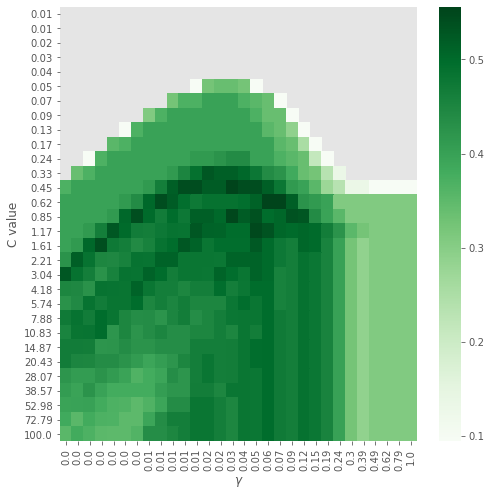

In [26]:
grid_search_SVM(train_data, test_data, train_labels, test_labels)

NER: 0.754, Sensitivity or recall: 0.936, Specificity: 0.571, Precision: 0.730, Correctly classified: 0.773, MCC: 0.555


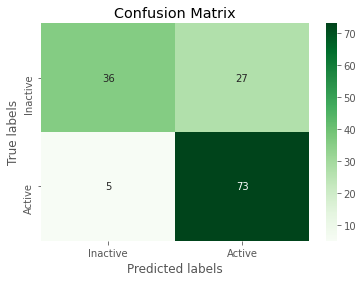

In [22]:
C= 0.788046
gamm = 0.0239502
svm = SVC(C=C, kernel="rbf", gamma=gamm)
svm.fit(train_data, train_labels)
predictions = svm.predict(test_data)
vals = print_metrics(predictions, test_labels)
plot_confusion(predictions, test_labels)

We test a similar approach with the SARS2 data set only

In [21]:
active_SARS2 = data_filtered["Is_active"]
train_data2, test_data2, train_labels2, test_labels2 = train_test_split(features_full, active_SARS2, test_size=0.25, random_state=42, stratify=active_SARS2)

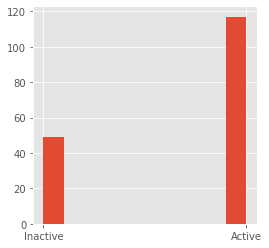

In [22]:
plt.figure(figsize=(4,4))
plt.hist(active_SARS2, bins=10);
plt.xticks([0, 1], ["Inactive", "Active"]);

C=0.01, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000,

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.01, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.0

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.01, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.01, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Preci

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=0.01610

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.014873521072935119, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: 

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.014873521072935119, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.014873521072935119, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.022122162910704492, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.7

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.022122162910704492, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: n

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.022122162910704492, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.022122162910704492, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.03290344562312668, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MC

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.03290344562312668, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.03290344562312668, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290344562312668, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.03290

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.04893900918477494, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MC

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.04893900918477494, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.04893900918477494, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.04893900918477494, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.048939

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.07278953843983153, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MC

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.07278953843983153, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.07278953843983153, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.07278953843983153, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.072789

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.10826367338740546, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC:

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=2.8072162039411785
NER

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.10826367338740546, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.10826367338740546, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392,

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.16102620275609392, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC:

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.16102620275609392, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.16102620275609392, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.16102620275609392, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, 

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.2395026619987486, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.2395026619987486, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.23950

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.2395026619987486, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.2395026619987486, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.35622478902624444, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC:

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.35622478902624444, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.35622478902624444, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.35622478902624444, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, g

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.529831690628371, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.529831690628371, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.52983169062

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.529831690628371, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.529831690628371, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=0.001


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.7880462815669912, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.7880462815669912, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.78804

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=0.7880462815669912, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=0.7880462815669912, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.1721022975334805, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.1721022975334805, gamma=0.00148735210

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=1.1721022975334805, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.1721022975334805, gamma=0.01610262027560939
NER: 0.525, Sensitivity or recall: 0.967, Specificity: 0.083, Precision: 0.725, Correctly classified: 0.714, MCC: 0.106
C=1.1721022975334805, gamma=0.02395026619987486
NER: 0.592, Sensitivity or recall: 0.933, Specificity: 0.250, Precision: 0.757, Correctly classified: 0.738, MCC: 0.256
C=1.1721022975334805, gamma=0.03562247890262444
NER: 0.550, Sensitivity or recall: 0.933, Specificity: 0.167, Precision: 0.737, Correctly classified: 0.714, MCC: 0.154
C=1.1721022975334805, gamma=0.0529831690628371
NER: 0.525, Sensitivity or recall: 0.967, Specificity: 0.083, Precision: 0.725, Correctly classified: 0.714, MCC: 0.106
C=1.1721022975334805, gamma=0.07880462815669913
NER: 0.483, Sensitivity or recall: 0.967, Specificity: 0.000, Precision: 0.707, Correctly classified: 0.690, MCC: 

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=1.1721022975334805, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.1721022975334805, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.1721022975334805, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.1721022975334805, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.1721022975334805, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.1721022975334805, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.1721022

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=1.1721022975334805, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.1721022975334805, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.1721022975334805, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.1721022975334805, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.743328822199989, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.743328822199989, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.743328822199989, gamma=0.0022122162

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.743328822199989, gamma=0.01610262027560939
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=1.743328822199989, gamma=0.02395026619987486
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=1.743328822199989, gamma=0.03562247890262444
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=1.743328822199989, gamma=0.0529831690628371
NER: 0.525, Sensitivity or recall: 0.967, Specificity: 0.083, Precision: 0.725, Correctly classified: 0.714, MCC: 0.106
C=1.743328822199989, gamma=0.07880462815669913
NER: 0.525, Sensitivity or recall: 0.967, Specificity: 0.083, Precision: 0.725, Correctly classified: 0.714, MCC: 0.106
C=1.743328822199989, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=1.743328822199989, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.743328822199989, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.743328822199989, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.743328822199989, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.743328822199989, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.743328822199989, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.7433288221999

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=1.743328822199989, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.743328822199989, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1.743328822199989, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=2.592943797404667, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=2.592943797404667, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=2.592943797404667, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=2.592943797404667, gamma=0.003290344562

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=2.592943797404667, gamma=0.02395026619987486
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=2.592943797404667, gamma=0.03562247890262444
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=2.592943797404667, gamma=0.0529831690628371
NER: 0.567, Sensitivity or recall: 0.967, Specificity: 0.167, Precision: 0.744, Correctly classified: 0.738, MCC: 0.234
C=2.592943797404667, gamma=0.07880462815669913
NER: 0.525, Sensitivity or recall: 0.967, Specificity: 0.083, Precision: 0.725, Correctly classified: 0.714, MCC: 0.106
C=2.592943797404667, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=2.592943797404667, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=2.

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=2.592943797404667, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=2.592943797404667, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=2.592943797404667, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=2.592943797404667, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=2.592943797404667, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=2.592943797404667, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=2.59294379740466

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=2.592943797404667, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=2.592943797404667, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=3.856620421163472, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=3.856620421163472, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=3.856620421163472, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=3.856620421163472, gamma=0.0032903445623126675
NER: 0.608, Sensitivity or recall: 0.967, Specificity: 0.250, Precision: 0.763, Correctly classified: 0.762, MCC: 0.333
C=3.856620421163472, gamma=0.00489

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=3.856620421163472, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=3.856620421163472, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=3.856620421163472, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=3.856620421163472, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=3.856620421163472, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=3.856620421163472, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=3.85662042116347

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=3.856620421163472, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=5.736152510448681, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=5.736152510448681, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=5.736152510448681, gamma=0.00221221629107045
NER: 0.608, Sensitivity or recall: 0.967, Specificity: 0.250, Precision: 0.763, Correctly classified: 0.762, MCC: 0.333
C=5.736152510448681, gamma=0.0032903445623126675
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=5.736152510448681, gamma=0.004893900918477494
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=5.736152510448681, gamma=

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=5.736152510448681, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=5.736152510448681, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=5.736152510448681, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=5.736152510448681, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=5.736152510448681, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=5.736152510448681, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=5.73615251044868

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=5.736152510448681, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=5.736152510448681, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=8.531678524172815, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=8.531678524172815, gamma=0.0014873521072935117
NER: 0.608, Sensitivity or recall: 0.967, Specificity: 0.250, Precision: 0.763, Correctly classified: 0.762, MCC: 0.333
C=8.531678524172815, gamma=0.00221221629107045
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=8.531678524172815, gamma=0.0032903445623126675
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=8.531678524172815, gamma=0.0

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=8.531678524172815, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=8.531678524172815, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=8.531678524172815, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=8.531678524172815, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=8.531678524172815, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=8.531678524172815, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=8.53167852417281

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=8.531678524172815, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=12.689610031679234, gamma=0.001
NER: 0.608, Sensitivity or recall: 0.967, Specificity: 0.250, Precision: 0.763, Correctly classified: 0.762, MCC: 0.333
C=12.689610031679234, gamma=0.0014873521072935117
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=12.689610031679234, gamma=0.00221221629107045
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=12.689610031679234, gamma=0.0032903445623126675
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=12.689610031679234, gamma=0.004893900918477494
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=12.6896100316792

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=12.689610031679234, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=12.689610031679234, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=12.689610031679234, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=12.689610031679234, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=12.689610031679234, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=12.689610031679234, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=12.6896100

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=12.689610031679234, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=18.873918221350976, gamma=0.001
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=18.873918221350976, gamma=0.0014873521072935117
NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344
C=18.873918221350976, gamma=0.00221221629107045
NER: 0.617, Sensitivity or recall: 0.900, Specificity: 0.333, Precision: 0.771, Correctly classified: 0.738, MCC: 0.283
C=18.873918221350976, gamma=0.0032903445623126675
NER: 0.600, Sensitivity or recall: 0.867, Specificity: 0.333, Precision: 0.765, Correctly classified: 0.714, MCC: 0.230
C=18.873918221350976, gamma=0.004893900918477494
NER: 0.675, Sensiti

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=18.873918221350976, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=18.873918221350976, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=18.873918221350976, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=18.873918221350976, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=18.873918221350976, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=18.873918221350976, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=18.8739182

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=18.873918221350976, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=18.873918221350976, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=28.072162039411786, gamma=0.001
NER: 0.617, Sensitivity or recall: 0.900, Specificity: 0.333, Precision: 0.771, Correctly classified: 0.738, MCC: 0.283
C=28.072162039411786, gamma=0.0014873521072935117
NER: 0.617, Sensitivity or recall: 0.900, Specificity: 0.333, Precision: 0.771, Correctly classified: 0.738, MCC: 0.283
C=28.072162039411786, gamma=0.00221221629107045
NER: 0.600, Sensitivity or recall: 0.867, Specificity: 0.333, Precision: 0.765, Correctly classified: 0.714, MCC: 0.230
C=28.072162039411786, gamma=0.0032903445623126675
NER: 0.675, Sensitivity or recall: 0.933, Specificity: 0.417, Precision: 0.800, Correctly classified: 0.786, MCC: 0.424
C=28.072162039411786, 

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=28.072162039411786, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=28.072162039411786, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=28.072162039411786, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=28.072162039411786, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=28.072162039411786, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=28.072162039411786, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=28.0721620

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=28.072162039411786, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=41.753189365604044, gamma=0.001
NER: 0.617, Sensitivity or recall: 0.900, Specificity: 0.333, Precision: 0.771, Correctly classified: 0.738, MCC: 0.283
C=41.753189365604044, gamma=0.0014873521072935117
NER: 0.600, Sensitivity or recall: 0.867, Specificity: 0.333, Precision: 0.765, Correctly classified: 0.714, MCC: 0.230
C=41.753189365604044, gamma=0.00221221629107045
NER: 0.658, Sensitivity or recall: 0.900, Specificity: 0.417, Precision: 0.794, Correctly classified: 0.762, MCC: 0.364
C=41.753189365604044, gamma=0.0032903445623126675
NER: 0.675, Sensitivity or recall: 0.933, Specificity: 0.417, Precision: 0.800, Correctly classified: 0.786, MCC: 0.424
C=41.753189365604044, gamma=0.004893900918477494
NER: 0.675, Sensitivity or recall: 0.933, Specificity: 0.417, Precision: 0.800, Correctly classified: 0.786, MCC: 0.424
C=41.753189365604

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=41.753189365604044, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=41.753189365604044, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=41.753189365604044, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=41.753189365604044, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=41.753189365604044, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=41.753189365604044, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=41.75318936

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=41.753189365604044, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=62.10169418915616, gamma=0.001
NER: 0.600, Sensitivity or recall: 0.867, Specificity: 0.333, Precision: 0.765, Correctly classified: 0.714, MCC: 0.230
C=62.10169418915616, gamma=0.0014873521072935117
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=62.10169418915616, gamma=0.00221221629107045
NER: 0.658, Sensitivity or recall: 0.900, Specificity: 0.417, Precision: 0.794, Correctly classified: 0.762, MCC: 0.364
C=62.10169418915616, gamma=0.0032903445623126675
NER: 0.675, Sensitivity or recall: 0.933, Specificity: 0.417, Precision: 0.800, Correctly classified: 0.786, MCC: 0.424
C=62.10169418915616, gamma=0.004893900918477494
NER: 0.675, Sensitivity or recall: 0.933, Specificity: 0.417, Precision: 0.800, Correctly classified: 0.786, MCC: 0.424
C=62.10169418915616, g

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=62.10169418915616, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=62.10169418915616, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=62.10169418915616, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=62.10169418915616, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=62.10169418915616, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=62.10169418915616, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=62.1016941891561

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=62.10169418915616, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=92.36708571873865, gamma=0.001
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=92.36708571873865, gamma=0.0014873521072935117
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=92.36708571873865, gamma=0.00221221629107045
NER: 0.658, Sensitivity or recall: 0.900, Specificity: 0.417, Precision: 0.794, Correctly classified: 0.762, MCC: 0.364
C=92.36708571873865, gamma=0.0032903445623126675
NER: 0.675, Sensitivity or recall: 0.933, Specificity: 0.417, Precision: 0.800, Correctly classified: 0.786, MCC: 0.424
C=92.36708571873865, gamma=0.004893900918477494
NER: 0.675, Sensitivity or recall: 0.933, Specificity: 0.417, Precision: 0.800, Correctly classified: 0.786, MCC: 0.424
C=92.36708571873865, ga

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=92.36708571873865, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=92.36708571873865, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=92.36708571873865, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=92.36708571873865, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=92.36708571873865, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=92.36708571873865, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=92.3670857187386

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=92.36708571873865, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=137.3823795883264, gamma=0.001
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=137.3823795883264, gamma=0.0014873521072935117
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=137.3823795883264, gamma=0.00221221629107045
NER: 0.658, Sensitivity or recall: 0.900, Specificity: 0.417, Precision: 0.794, Correctly classified: 0.762, MCC: 0.364
C=137.3823795883264, gamma=0.0032903445623126675
NER: 0.675, Sensitivity or recall: 0.933, Specificity: 0.417, Precision: 0.800, Correctly classified: 0.786, MCC: 0.424
C=137.3823795883264, gamma=0.004893900918477494
NER: 0.675, Sensitivity or recall: 0.933, Specificity: 0.417, Precision: 0.800, Correctly classified: 0.786, MCC: 0.424
C=137.3823795883264, ga

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=137.3823795883264, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=137.3823795883264, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=137.3823795883264, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=137.3823795883264, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=137.3823795883264, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=137.3823795883264, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=137.382379588326

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=137.3823795883264, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=137.3823795883264, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=204.33597178569437, gamma=0.001
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=204.33597178569437, gamma=0.0014873521072935117
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=204.33597178569437, gamma=0.00221221629107045
NER: 0.658, Sensitivity or recall: 0.900, Specificity: 0.417, Precision: 0.794, Correctly classified: 0.762, MCC: 0.364
C=204.33597178569437, gamma=0.0032903445623126675
NER: 0.675, Sensitivity or recall: 0.933, Specificity: 0.417, Precision: 0.800, Correctly classified: 0.786, MCC: 0.424
C=204.33597178569437, ga

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=204.33597178569437, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=204.33597178569437, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=204.33597178569437, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=204.33597178569437, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=204.33597178569437, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=204.33597178569437, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=204.335971

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=204.33597178569437, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=204.33597178569437, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=204.33597178569437, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=303.91953823132013, gamma=0.001
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=303.91953823132013, gamma=0.0014873521072935117
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=303.91953823132013, gamma=0.00221221629107045
NER: 0.658, Sensitivity or recall: 0.900, Specificity: 0.417, Precision: 0.794, Correctly classified: 0.762, MCC: 0.364
C=303.91953823132013, gamma=0

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=303.91953823132013, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=303.91953823132013, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=303.91953823132013, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=303.91953823132013, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=303.91953823132013, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=303.91953823132013, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=303.91953

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=303.91953823132013, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=303.91953823132013, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=303.91953823132013, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=452.035365636025, gamma=0.001
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=452.035365636025, gamma=0.0014873521072935117
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=452.035365636025, gamma=0.00221221629107045
NER: 0.658, Sensitivity or recall: 0.900, Specificity: 0.417, Precision: 0.794, Correctly classified: 0.762, MCC: 0.364
C=452.035365636025, gamma=0.0032903

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=452.035365636025, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=452.035365636025, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=452.035365636025, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=452.035365636025, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=452.035365636025, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=452.035365636025, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=452.035365636025, gam

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=452.035365636025, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=452.035365636025, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=452.035365636025, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=672.3357536499335, gamma=0.001
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=672.3357536499335, gamma=0.0014873521072935117
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=672.3357536499335, gamma=0.00221221629107045
NER: 0.658, Sensitivity or recall: 0.900, Specificity: 0.417, Precision: 0.794, Correctly classified: 0.762, MCC: 0.364
C=672.3357536499335, gamma=0.003290344

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=672.3357536499335, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=672.3357536499335, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=672.3357536499335, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=672.3357536499335, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=672.3357536499335, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=672.3357536499335, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=672.33575364993

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=672.3357536499335, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=672.3357536499335, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=672.3357536499335, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1000.0, gamma=0.001
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=1000.0, gamma=0.0014873521072935117
NER: 0.642, Sensitivity or recall: 0.867, Specificity: 0.417, Precision: 0.788, Correctly classified: 0.738, MCC: 0.312
C=1000.0, gamma=0.00221221629107045
NER: 0.658, Sensitivity or recall: 0.900, Specificity: 0.417, Precision: 0.794, Correctly classified: 0.762, MCC: 0.364
C=1000.0, gamma=0.0032903445623126675
NER: 0.675, Sensitivity or rec

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=1000.0, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1000.0, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1000.0, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1000.0, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1000.0, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1000.0, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1000.0, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specifi

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encou

C=1000.0, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1000.0, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan
C=1000.0, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.714, Correctly classified: 0.714, MCC: nan


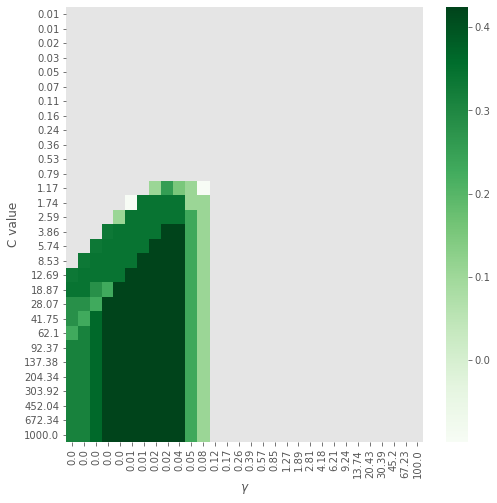

In [24]:
grid_search_SVM(train_data2, test_data2, train_labels2, test_labels2)

NER: 0.633, Sensitivity or recall: 0.933, Specificity: 0.333, Precision: 0.778, Correctly classified: 0.762, MCC: 0.344


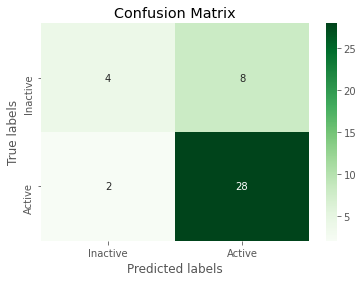

In [25]:
C= 1.743328
gamm = 0.02395
svm = SVC(C=C, kernel="rbf", gamma=gamm)
svm.fit(train_data2, train_labels2)
predictions = svm.predict(test_data2)
vals = print_metrics(predictions, test_labels2)
plot_confusion(predictions, test_labels2)

Try with the SARS1 data set only

In [257]:
train_data1, test_data1, train_labels1, test_labels1 = train_test_split(features_GHDDI, active_SARS1, test_size=0.25, random_state=42, stratify=active_SARS1)

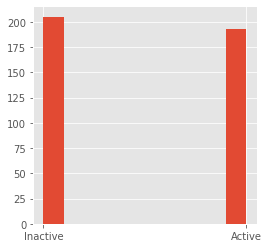

In [258]:
plt.figure(figsize=(4,4))
plt.hist(active_SARS1, bins=10);
plt.xticks([0, 1], ["Inactive", "Active"]);

C=0.01, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=0.01373823795883263
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.017433288221999882
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=0.022122162910704492
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.02807216203941177
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=0.035622478902624426
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.04520353656360243
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=0.057361525104486784
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.0727895384398315
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=0.09236708571873861
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01, gamma=1.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=0.01373823795883263
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.017433288221999882
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=0.022122162910704492
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.02807216203941177
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=0.035622478902624426
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.04520353656360243
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=0.057361525104486784
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.0727895384398315
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=0.09236708571873861
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01373823795883263, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.01373823795883263, gamma=1.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=0.01373823795883263
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.017433288221999882
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=0.022122162910704492
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.02807216203941177
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=0.035622478902624426
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.04520353656360243
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=0.057361525104486784
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.0727895384398315
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=0.09236708571873861
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.018873918221350976, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.018873918221350976, gamma=1.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=0.01373823795883263
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.017433288221999882
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=0.022122162910704492
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.02807216203941177
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=0.035622478902624426
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.04520353656360243
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=0.057361525104486784
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.0727895384398315
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=0.09236708571873861
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.02592943797404667, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.02592943797404667, gamma=1.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.035622478902624426, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.035622478902624426, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.035622478902624426, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.035622478902624426, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.035622478902624426, gamma=0.008531678524172805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.035622478902624426, gamma=0.01373823795883263
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.017433288221999882
NER: 0.521, Sensitivity or recall: 0.042, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.540, MCC: 0.149
C=0.035622478902624426, gamma=0.022122162910704492
NER: 0.531, Sensitivity or recall: 0.062, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.550, MCC: 0.183
C=0.035622478902624426, gamma=0.02807216203941177
NER: 0.531, Sensitivity or recall: 0.062, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.550, MCC: 0.183
C=0.035622478902624426, gamma=0.035622478902624426
NER: 0.521, Sensitivity or recall: 0.042, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.540, MCC: 0.149
C=0.035622478902624426, gamma=0.04520353656360243
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.035622478902624426, gamma=0.057361525104486784
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 

<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.0727895384398315
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.035622478902624426, gamma=0.09236708571873861
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.035622478902624426, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.035622478902624426, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.035622478902624426, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.035622478902624426, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.035622478902624426, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.035622478902624426, gamma=1.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.04893900918477494, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.04893900918477494, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.04893900918477494, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.04893900918477494, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.006723357536499335
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.04893900918477494, gamma=0.008531678524172805
NER: 0.521, Sensitivity or recall: 0.042, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.540, MCC: 0.149


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.010826367338740546
NER: 0.542, Sensitivity or recall: 0.083, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.560, MCC: 0.212
C=0.04893900918477494, gamma=0.01373823795883263
NER: 0.648, Sensitivity or recall: 0.354, Specificity: 0.942, Precision: 0.850, Correctly classified: 0.660, MCC: 0.370
C=0.04893900918477494, gamma=0.017433288221999882
NER: 0.690, Sensitivity or recall: 0.438, Specificity: 0.942, Precision: 0.875, Correctly classified: 0.700, MCC: 0.444
C=0.04893900918477494, gamma=0.022122162910704492
NER: 0.721, Sensitivity or recall: 0.500, Specificity: 0.942, Precision: 0.889, Correctly classified: 0.730, MCC: 0.498
C=0.04893900918477494, gamma=0.02807216203941177
NER: 0.721, Sensitivity or recall: 0.500, Specificity: 0.942, Precision: 0.889, Correctly classified: 0.730, MCC: 0.498
C=0.04893900918477494, gamma=0.035622478902624426
NER: 0.669, Sensitivity or recall: 0.396, Specificity: 0.942, Precision: 0.864, Correctly classified: 

<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.04893900918477494, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.04893900918477494, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.04893900918477494, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.04893900918477494, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.04893900918477494, gamma=1.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.06723357536499334, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.06723357536499334, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.06723357536499334, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.0041753189365604
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.06723357536499334, gamma=0.005298316906283708
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.006723357536499335
NER: 0.573, Sensitivity or recall: 0.146, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.590, MCC: 0.286
C=0.06723357536499334, gamma=0.008531678524172805
NER: 0.700, Sensitivity or recall: 0.458, Specificity: 0.942, Precision: 0.880, Correctly classified: 0.710, MCC: 0.462
C=0.06723357536499334, gamma=0.010826367338740546
NER: 0.735, Sensitivity or recall: 0.604, Specificity: 0.865, Precision: 0.806, Correctly classified: 0.740, MCC: 0.489
C=0.06723357536499334, gamma=0.01373823795883263
NER: 0.780, Sensitivity or recall: 0.771, Specificity: 0.788, Precision: 0.771, Correctly classified: 0.780, MCC: 0.559
C=0.06723357536499334, gamma=0.017433288221999882
NER: 0.744, Sensitivity or recall: 0.833, Specificity: 0.654, Precision: 0.690, Correctly classified: 0.740, MCC: 0.493
C=0.06723357536499334, gamma=0.022122162910704492
NER: 0.755, Sensitivity or recall: 0.875, Specificity: 0.635, Precision: 0.689, Correctly classified:

<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.06723357536499334, gamma=0.14873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.06723357536499334, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.06723357536499334, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.06723357536499334, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.06723357536499334, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.06723357536499334, gamma=1.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.09236708571873861, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.09236708571873861, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.002592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.09236708571873861, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.0041753189365604
NER: 0.542, Sensitivity or recall: 0.083, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.560, MCC: 0.212
C=0.09236708571873861, gamma=0.005298316906283708
NER: 0.700, Sensitivity or recall: 0.458, Specificity: 0.942, Precision: 0.880, Correctly classified: 0.710, MCC: 0.462
C=0.09236708571873861, gamma=0.006723357536499335
NER: 0.756, Sensitivity or recall: 0.646, Specificity: 0.865, Precision: 0.816, Correctly classified: 0.760, MCC: 0.526
C=0.09236708571873861, gamma=0.008531678524172805
NER: 0.751, Sensitivity or recall: 0.771, Specificity: 0.731, Precision: 0.725, Correctly classified: 0.750, MCC: 0.501
C=0.09236708571873861, gamma=0.010826367338740546
NER: 0.733, Sensitivity or recall: 0.812, Specificity: 0.654, Precision: 0.684, Correctly classified: 0.730, MCC: 0.471
C=0.09236708571873861, gamma=0.01373823795883263
NER: 0.744, Sensitivity or recall: 0.854, Specificity: 0.635, Precision: 0.683, Correctly classified: 0

<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.09236708571873861, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.09236708571873861, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.09236708571873861, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.09236708571873861, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.09236708571873861, gamma=1.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.12689610031679222, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.12689610031679222, gamma=0.0020433597178569417
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.002592943797404667
NER: 0.521, Sensitivity or recall: 0.042, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.540, MCC: 0.149
C=0.12689610031679222, gamma=0.0032903445623126675
NER: 0.648, Sensitivity or recall: 0.354, Specificity: 0.942, Precision: 0.850, Correctly classified: 0.660, MCC: 0.370
C=0.12689610031679222, gamma=0.0041753189365604
NER: 0.724, Sensitivity or recall: 0.562, Specificity: 0.885, Precision: 0.818, Correctly classified: 0.730, MCC: 0.475
C=0.12689610031679222, gamma=0.005298316906283708
NER: 0.751, Sensitivity or recall: 0.771, Specificity: 0.731, Precision: 0.725, Correctly classified: 0.750, MCC: 0.501
C=0.12689610031679222, gamma=0.006723357536499335
NER: 0.761, Sensitivity or recall: 0.792, Specificity: 0.731, Precision: 0.731, Correctly classified: 0.760, MCC: 0.522
C=0.12689610031679222, gamma=0.008531678524172805
NER: 0.743, Sensitivity or recall: 0.812, Specificity: 0.673, Precision: 0.696, Correctly classified:

<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.18873918221350977
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.12689610031679222, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.12689610031679222, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.12689610031679222, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.12689610031679222, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.12689610031679222, gamma=1.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.17433288221999882, gamma=0.0012689610031679222
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.0016102620275609393
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.17433288221999882, gamma=0.0020433597178569417
NER: 0.552, Sensitivity or recall: 0.104, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.570, MCC: 0.239
C=0.17433288221999882, gamma=0.002592943797404667
NER: 0.711, Sensitivity or recall: 0.479, Specificity: 0.942, Precision: 0.885, Correctly classified: 0.720, MCC: 0.480
C=0.17433288221999882, gamma=0.0032903445623126675
NER: 0.758, Sensitivity or recall: 0.708, Specificity: 0.808, Precision: 0.773, Correctly classified: 0.760, MCC: 0.519
C=0.17433288221999882, gamma=0.0041753189365604
NER: 0.751, Sensitivity or recall: 0.771, Specificity: 0.731, Precision: 0.725, Correctly classified: 0.750, MCC: 0.501
C=0.17433288221999882, gamma=0.005298316906283708
NER: 0.761, Sensitivity or recall: 0.792, Specificity: 0.731, Precision: 0.731, Correctly classified: 0

<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.2395026619987486
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.17433288221999882, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.17433288221999882, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.17433288221999882, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.17433288221999882, gamma=1.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.2395026619987486, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.0012689610031679222
NER: 0.521, Sensitivity or recall: 0.042, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.540, MCC: 0.149
C=0.2395026619987486, gamma=0.0016102620275609393
NER: 0.648, Sensitivity or recall: 0.354, Specificity: 0.942, Precision: 0.850, Correctly classified: 0.660, MCC: 0.370
C=0.2395026619987486, gamma=0.0020433597178569417
NER: 0.724, Sensitivity or recall: 0.562, Specificity: 0.885, Precision: 0.818, Correctly classified: 0.730, MCC: 0.475
C=0.2395026619987486, gamma=0.002592943797404667
NER: 0.751, Sensitivity or recall: 0.771, Specificity: 0.731, Precision: 0.725, Correctly classified: 0.750, MCC: 0.501
C=0.2395026619987486, gamma=0.0032903445623126675
NER: 0.761, Sensitivity or recall: 0.792, Specificity: 0.731, Precision: 0.731, Correctly classified: 0.760, MCC: 0.522
C=0.2395026619987486, gamma=0.0041753189365604
NER: 0.761, Sensitivity or recall: 0.792, Specificity: 0.731, Precision: 0.731, Correctly classified: 0.

<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.3039195382313198
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.2395026619987486, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.4893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.2395026619987486, gamma=0.6210169418915616
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.2395026619987486, gamma=1.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.32903445623126676, gamma=0.001
NER: 0.542, Sensitivity or recall: 0.083, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.560, MCC: 0.212
C=0.32903445623126676, gamma=0.0012689610031679222
NER: 0.711, Sensitivity or recall: 0.479, Specificity: 0.942, Precision: 0.885, Correctly classified: 0.720, MCC: 0.480
C=0.32903445623126676, gamma=0.0016102620275609393
NER: 0.748, Sensitivity or recall: 0.688, Specificity: 0.808, Precision: 0.767, Correctly classified: 0.750, MCC: 0.500
C=0.32903445623126676, gamma=0.0020433597178569417
NER: 0.751, Sensitivity or recall: 0.771, Specificity: 0.731, Precision: 0.725, Correctly classified: 0.750, MCC: 0.501
C=0.32903445623126676, gamma=0.002592943797404667
NER: 0.761, Sensitivity or recall: 0.792, Specificity: 0.731, Precision: 0.731, Correctly classified: 0.760, MCC: 0.522
C=0.32903445623126676, gamma=0.0032903445623126675
NER: 0.770, Sensitivity or recall: 0.771, Specificity: 0.769, Precision: 0.755, Correctly classified: 0.770, MC

<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.32903445623126676, gamma=0.7880462815669912
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan
C=0.32903445623126676, gamma=1.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.520, MCC: nan


<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-80-0da7e4f1a456>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.4520353656360243, gamma=0.001
NER: 0.713, Sensitivity or recall: 0.542, Specificity: 0.885, Precision: 0.812, Correctly classified: 0.720, MCC: 0.457
C=0.4520353656360243, gamma=0.0012689610031679222
NER: 0.760, Sensitivity or recall: 0.771, Specificity: 0.750, Precision: 0.740, Correctly classified: 0.760, MCC: 0.520
C=0.4520353656360243, gamma=0.0016102620275609393
NER: 0.751, Sensitivity or recall: 0.771, Specificity: 0.731, Precision: 0.725, Correctly classified: 0.750, MCC: 0.501
C=0.4520353656360243, gamma=0.0020433597178569417
NER: 0.761, Sensitivity or recall: 0.792, Specificity: 0.731, Precision: 0.731, Correctly classified: 0.760, MCC: 0.522
C=0.4520353656360243, gamma=0.002592943797404667
NER: 0.769, Sensitivity or recall: 0.750, Specificity: 0.788, Precision: 0.766, Correctly classified: 0.770, MCC: 0.539
C=0.4520353656360243, gamma=0.0032903445623126675
NER: 0.798, Sensitivity or recall: 0.750, Specificity: 0.846, Precision: 0.818, Correctly classified: 0.800, MCC: 0.6

C=0.6210169418915616, gamma=0.11721022975334805
NER: 0.783, Sensitivity or recall: 0.854, Specificity: 0.712, Precision: 0.732, Correctly classified: 0.780, MCC: 0.569
C=0.6210169418915616, gamma=0.14873521072935117
NER: 0.737, Sensitivity or recall: 0.917, Specificity: 0.558, Precision: 0.657, Correctly classified: 0.730, MCC: 0.504
C=0.6210169418915616, gamma=0.18873918221350977
NER: 0.681, Sensitivity or recall: 0.958, Specificity: 0.404, Precision: 0.597, Correctly classified: 0.670, MCC: 0.430
C=0.6210169418915616, gamma=0.2395026619987486
NER: 0.663, Sensitivity or recall: 0.979, Specificity: 0.346, Precision: 0.580, Correctly classified: 0.650, MCC: 0.414
C=0.6210169418915616, gamma=0.3039195382313198
NER: 0.663, Sensitivity or recall: 0.979, Specificity: 0.346, Precision: 0.580, Correctly classified: 0.650, MCC: 0.414
C=0.6210169418915616, gamma=0.38566204211634725
NER: 0.653, Sensitivity or recall: 0.979, Specificity: 0.327, Precision: 0.573, Correctly classified: 0.640, MCC: 

C=1.1721022975334805, gamma=0.017433288221999882
NER: 0.829, Sensitivity or recall: 0.812, Specificity: 0.846, Precision: 0.830, Correctly classified: 0.830, MCC: 0.659
C=1.1721022975334805, gamma=0.022122162910704492
NER: 0.829, Sensitivity or recall: 0.812, Specificity: 0.846, Precision: 0.830, Correctly classified: 0.830, MCC: 0.659
C=1.1721022975334805, gamma=0.02807216203941177
NER: 0.829, Sensitivity or recall: 0.812, Specificity: 0.846, Precision: 0.830, Correctly classified: 0.830, MCC: 0.659
C=1.1721022975334805, gamma=0.035622478902624426
NER: 0.829, Sensitivity or recall: 0.812, Specificity: 0.846, Precision: 0.830, Correctly classified: 0.830, MCC: 0.659
C=1.1721022975334805, gamma=0.04520353656360243
NER: 0.829, Sensitivity or recall: 0.792, Specificity: 0.865, Precision: 0.844, Correctly classified: 0.830, MCC: 0.660
C=1.1721022975334805, gamma=0.057361525104486784
NER: 0.818, Sensitivity or recall: 0.771, Specificity: 0.865, Precision: 0.841, Correctly classified: 0.820,

C=2.212216291070448, gamma=0.0016102620275609393
NER: 0.799, Sensitivity or recall: 0.771, Specificity: 0.827, Precision: 0.804, Correctly classified: 0.800, MCC: 0.599
C=2.212216291070448, gamma=0.0020433597178569417
NER: 0.820, Sensitivity or recall: 0.812, Specificity: 0.827, Precision: 0.812, Correctly classified: 0.820, MCC: 0.639
C=2.212216291070448, gamma=0.002592943797404667
NER: 0.820, Sensitivity or recall: 0.812, Specificity: 0.827, Precision: 0.812, Correctly classified: 0.820, MCC: 0.639
C=2.212216291070448, gamma=0.0032903445623126675
NER: 0.820, Sensitivity or recall: 0.812, Specificity: 0.827, Precision: 0.812, Correctly classified: 0.820, MCC: 0.639
C=2.212216291070448, gamma=0.0041753189365604
NER: 0.829, Sensitivity or recall: 0.812, Specificity: 0.846, Precision: 0.830, Correctly classified: 0.830, MCC: 0.659
C=2.212216291070448, gamma=0.005298316906283708
NER: 0.829, Sensitivity or recall: 0.812, Specificity: 0.846, Precision: 0.830, Correctly classified: 0.830, MC

C=3.039195382313198, gamma=0.18873918221350977
NER: 0.763, Sensitivity or recall: 0.833, Specificity: 0.692, Precision: 0.714, Correctly classified: 0.760, MCC: 0.529
C=3.039195382313198, gamma=0.2395026619987486
NER: 0.736, Sensitivity or recall: 0.875, Specificity: 0.596, Precision: 0.667, Correctly classified: 0.730, MCC: 0.488
C=3.039195382313198, gamma=0.3039195382313198
NER: 0.679, Sensitivity or recall: 0.917, Specificity: 0.442, Precision: 0.603, Correctly classified: 0.670, MCC: 0.404
C=3.039195382313198, gamma=0.38566204211634725
NER: 0.681, Sensitivity or recall: 0.958, Specificity: 0.404, Precision: 0.597, Correctly classified: 0.670, MCC: 0.430
C=3.039195382313198, gamma=0.4893900918477494
NER: 0.662, Sensitivity or recall: 0.958, Specificity: 0.365, Precision: 0.582, Correctly classified: 0.650, MCC: 0.397
C=3.039195382313198, gamma=0.6210169418915616
NER: 0.643, Sensitivity or recall: 0.958, Specificity: 0.327, Precision: 0.568, Correctly classified: 0.630, MCC: 0.363
C=

C=5.736152510448681, gamma=0.022122162910704492
NER: 0.818, Sensitivity or recall: 0.771, Specificity: 0.865, Precision: 0.841, Correctly classified: 0.820, MCC: 0.640
C=5.736152510448681, gamma=0.02807216203941177
NER: 0.828, Sensitivity or recall: 0.771, Specificity: 0.885, Precision: 0.860, Correctly classified: 0.830, MCC: 0.661
C=5.736152510448681, gamma=0.035622478902624426
NER: 0.807, Sensitivity or recall: 0.729, Specificity: 0.885, Precision: 0.854, Correctly classified: 0.810, MCC: 0.623
C=5.736152510448681, gamma=0.04520353656360243
NER: 0.796, Sensitivity or recall: 0.708, Specificity: 0.885, Precision: 0.850, Correctly classified: 0.800, MCC: 0.605
C=5.736152510448681, gamma=0.057361525104486784
NER: 0.776, Sensitivity or recall: 0.667, Specificity: 0.885, Precision: 0.842, Correctly classified: 0.780, MCC: 0.567
C=5.736152510448681, gamma=0.0727895384398315
NER: 0.796, Sensitivity or recall: 0.708, Specificity: 0.885, Precision: 0.850, Correctly classified: 0.800, MCC: 0.

C=10.82636733874054, gamma=0.002592943797404667
NER: 0.830, Sensitivity or recall: 0.833, Specificity: 0.827, Precision: 0.816, Correctly classified: 0.830, MCC: 0.660
C=10.82636733874054, gamma=0.0032903445623126675
NER: 0.800, Sensitivity or recall: 0.792, Specificity: 0.808, Precision: 0.792, Correctly classified: 0.800, MCC: 0.599
C=10.82636733874054, gamma=0.0041753189365604
NER: 0.800, Sensitivity or recall: 0.792, Specificity: 0.808, Precision: 0.792, Correctly classified: 0.800, MCC: 0.599
C=10.82636733874054, gamma=0.005298316906283708
NER: 0.800, Sensitivity or recall: 0.792, Specificity: 0.808, Precision: 0.792, Correctly classified: 0.800, MCC: 0.599
C=10.82636733874054, gamma=0.006723357536499335
NER: 0.800, Sensitivity or recall: 0.792, Specificity: 0.808, Precision: 0.792, Correctly classified: 0.800, MCC: 0.599
C=10.82636733874054, gamma=0.008531678524172805
NER: 0.809, Sensitivity or recall: 0.792, Specificity: 0.827, Precision: 0.809, Correctly classified: 0.810, MCC:

C=14.873521072935118, gamma=0.3039195382313198
NER: 0.679, Sensitivity or recall: 0.917, Specificity: 0.442, Precision: 0.603, Correctly classified: 0.670, MCC: 0.404
C=14.873521072935118, gamma=0.38566204211634725
NER: 0.681, Sensitivity or recall: 0.958, Specificity: 0.404, Precision: 0.597, Correctly classified: 0.670, MCC: 0.430
C=14.873521072935118, gamma=0.4893900918477494
NER: 0.662, Sensitivity or recall: 0.958, Specificity: 0.365, Precision: 0.582, Correctly classified: 0.650, MCC: 0.397
C=14.873521072935118, gamma=0.6210169418915616
NER: 0.643, Sensitivity or recall: 0.958, Specificity: 0.327, Precision: 0.568, Correctly classified: 0.630, MCC: 0.363
C=14.873521072935118, gamma=0.7880462815669912
NER: 0.643, Sensitivity or recall: 0.958, Specificity: 0.327, Precision: 0.568, Correctly classified: 0.630, MCC: 0.363
C=14.873521072935118, gamma=1.0
NER: 0.653, Sensitivity or recall: 0.979, Specificity: 0.327, Precision: 0.573, Correctly classified: 0.640, MCC: 0.398
C=20.4335971

C=28.072162039411758, gamma=0.035622478902624426
NER: 0.808, Sensitivity or recall: 0.750, Specificity: 0.865, Precision: 0.837, Correctly classified: 0.810, MCC: 0.621
C=28.072162039411758, gamma=0.04520353656360243
NER: 0.797, Sensitivity or recall: 0.729, Specificity: 0.865, Precision: 0.833, Correctly classified: 0.800, MCC: 0.602
C=28.072162039411758, gamma=0.057361525104486784
NER: 0.776, Sensitivity or recall: 0.688, Specificity: 0.865, Precision: 0.825, Correctly classified: 0.780, MCC: 0.564
C=28.072162039411758, gamma=0.0727895384398315
NER: 0.807, Sensitivity or recall: 0.729, Specificity: 0.885, Precision: 0.854, Correctly classified: 0.810, MCC: 0.623
C=28.072162039411758, gamma=0.09236708571873861
NER: 0.796, Sensitivity or recall: 0.708, Specificity: 0.885, Precision: 0.850, Correctly classified: 0.800, MCC: 0.605
C=28.072162039411758, gamma=0.11721022975334805
NER: 0.786, Sensitivity or recall: 0.688, Specificity: 0.885, Precision: 0.846, Correctly classified: 0.790, MC

C=52.98316906283707, gamma=0.0032903445623126675
NER: 0.829, Sensitivity or recall: 0.792, Specificity: 0.865, Precision: 0.844, Correctly classified: 0.830, MCC: 0.660
C=52.98316906283707, gamma=0.0041753189365604
NER: 0.829, Sensitivity or recall: 0.792, Specificity: 0.865, Precision: 0.844, Correctly classified: 0.830, MCC: 0.660
C=52.98316906283707, gamma=0.005298316906283708
NER: 0.798, Sensitivity or recall: 0.750, Specificity: 0.846, Precision: 0.818, Correctly classified: 0.800, MCC: 0.600
C=52.98316906283707, gamma=0.006723357536499335
NER: 0.768, Sensitivity or recall: 0.729, Specificity: 0.808, Precision: 0.778, Correctly classified: 0.770, MCC: 0.539
C=52.98316906283707, gamma=0.008531678524172805
NER: 0.759, Sensitivity or recall: 0.729, Specificity: 0.788, Precision: 0.761, Correctly classified: 0.760, MCC: 0.519
C=52.98316906283707, gamma=0.010826367338740546
NER: 0.769, Sensitivity or recall: 0.750, Specificity: 0.788, Precision: 0.766, Correctly classified: 0.770, MCC:

C=72.78953843983146, gamma=0.4893900918477494
NER: 0.662, Sensitivity or recall: 0.958, Specificity: 0.365, Precision: 0.582, Correctly classified: 0.650, MCC: 0.397
C=72.78953843983146, gamma=0.6210169418915616
NER: 0.643, Sensitivity or recall: 0.958, Specificity: 0.327, Precision: 0.568, Correctly classified: 0.630, MCC: 0.363
C=72.78953843983146, gamma=0.7880462815669912
NER: 0.643, Sensitivity or recall: 0.958, Specificity: 0.327, Precision: 0.568, Correctly classified: 0.630, MCC: 0.363
C=72.78953843983146, gamma=1.0
NER: 0.653, Sensitivity or recall: 0.979, Specificity: 0.327, Precision: 0.573, Correctly classified: 0.640, MCC: 0.398
C=100.0, gamma=0.001
NER: 0.809, Sensitivity or recall: 0.792, Specificity: 0.827, Precision: 0.809, Correctly classified: 0.810, MCC: 0.619
C=100.0, gamma=0.0012689610031679222
NER: 0.819, Sensitivity or recall: 0.792, Specificity: 0.846, Precision: 0.826, Correctly classified: 0.820, MCC: 0.639
C=100.0, gamma=0.0016102620275609393
NER: 0.819, Sens

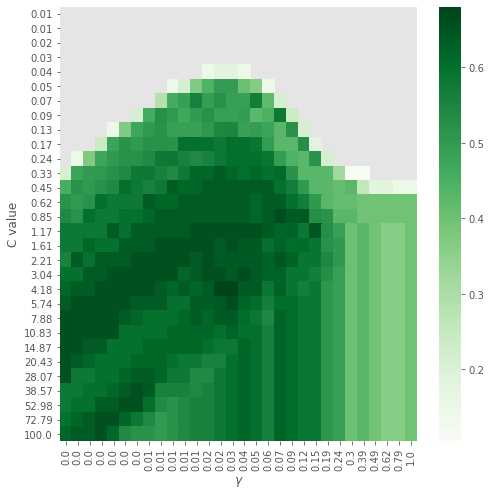

In [259]:
grid_search_SVM(train_data1, test_data1, train_labels1, test_labels1)

NER: 0.838, Sensitivity or recall: 0.792, Specificity: 0.885, Precision: 0.864, Correctly classified: 0.840, MCC: 0.681


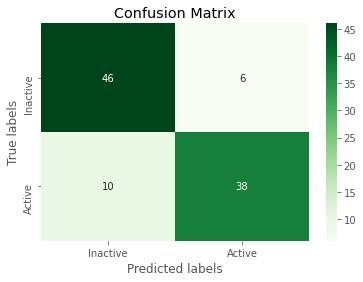

In [260]:
C= 4.17531
gamm = 0.02807
svm = SVC(C=C, kernel="rbf", gamma=gamm)
svm.fit(train_data1, train_labels1)
predictions = svm.predict(test_data1)
vals = print_metrics(predictions, test_labels1)
plot_confusion(predictions, test_labels1)

Train with SARS1, test with SARS2 

C=0.01, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan
C=0.01, gamma=0.0014873521072935117


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan
C=0.01, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan
C=0.01, gamma=0.007278953843983154


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan
C=0.01, gamma=0.010826367338740546


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan
C=0.01, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan
C=0.01, gamma=0.07880462815669913


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan
C=0.01, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan
C=0.01, gamma=1.8873918221350976


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan
C=0.01, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan
C=0.01, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=100.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=100.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=100.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=100.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.01610262027560939
NER: 0.429, Sensitivity or recall: 0.103, Specificity: 0.755, Precision: 0.500, Correctly classified: 0.295, MCC: -0.185
C=0.04893900918477494, gamma=0.02395026619987486
NER: 0.335, Sensitivity or recall: 0.487, Specificity: 0.184, Precision: 0.588, Correctly classified: 0.398, MCC: -0.305
C=0.04893900918477494, gamma=0.03562247890262444
NER: 0.371, Sensitivity or recall: 0.538, Specificity: 0.204, Precision: 0.618, Correctly classified: 0.440, MCC: -0.241
C=0.04893900918477494, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=100.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.007278953843983154
NER: 0.431, Sensitivity or recall: 0.026, Specificity: 0.837, Precision: 0.273, Correctly classified: 0.265, MCC: -0.252
C=0.07278953843983153, gamma=0.010826367338740546
NER: 0.395, Sensitivity or recall: 0.402, Specificity: 0.388, Precision: 0.610, Correctly classified: 0.398, MCC: -0.193
C=0.07278953843983153, gamma=0.01610262027560939
NER: 0.369, Sensitivity or recall: 0.453, Specificity: 0.286, Precision: 0.602, Correctly classified: 0.404, MCC: -0.239
C=0.07278953843983153, gamma=0.02395026619987486
NER: 0.361, Sensitivity or recall: 0.538, Specificity: 0.184, Precision: 0.612, Correctly classified: 0.434, MCC: -0.261
C=0.07278953843983153, gamma=0.03562247890262444
NER: 0.443, Sensitivity or recall: 0.846, Specificity: 0.041, Precision: 0.678, Correctly classified: 0.608, MCC: -0.158
C=0.07278953843983153, gamma=0.0529831690628371
NER: 0.483, Sensitivity or recall: 0.966, Specificity: 0.000, Precision: 0.698, Correctly classified

<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=100.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.004893900918477494
NER: 0.409, Sensitivity or recall: 0.145, Specificity: 0.673, Precision: 0.515, Correctly classified: 0.301, MCC: -0.207
C=0.10826367338740546, gamma=0.007278953843983154
NER: 0.399, Sensitivity or recall: 0.248, Specificity: 0.551, Precision: 0.569, Correctly classified: 0.337, MCC: -0.199
C=0.10826367338740546, gamma=0.010826367338740546
NER: 0.433, Sensitivity or recall: 0.214, Specificity: 0.653, Precision: 0.595, Correctly classified: 0.343, MCC: -0.140
C=0.10826367338740546, gamma=0.01610262027560939
NER: 0.443, Sensitivity or recall: 0.171, Specificity: 0.714, Precision: 0.588, Correctly classified: 0.331, MCC: -0.130
C=0.10826367338740546, gamma=0.02395026619987486
NER: 0.382, Sensitivity or recall: 0.274, Specificity: 0.490, Precision: 0.561, Correctly classified: 0.337, MCC: -0.227
C=0.10826367338740546, gamma=0.03562247890262444
NER: 0.365, Sensitivity or recall: 0.547, Specificity: 0.184, Precision: 0.615, Correctly classifi

<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=100.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.0032903445623126675
NER: 0.419, Sensitivity or recall: 0.205, Specificity: 0.633, Precision: 0.571, Correctly classified: 0.331, MCC: -0.170
C=0.16102620275609392, gamma=0.004893900918477494
NER: 0.436, Sensitivity or recall: 0.137, Specificity: 0.735, Precision: 0.552, Correctly classified: 0.313, MCC: -0.154
C=0.16102620275609392, gamma=0.007278953843983154
NER: 0.442, Sensitivity or recall: 0.068, Specificity: 0.816, Precision: 0.471, Correctly classified: 0.289, MCC: -0.173
C=0.16102620275609392, gamma=0.010826367338740546
NER: 0.450, Sensitivity or recall: 0.043, Specificity: 0.857, Precision: 0.417, Correctly classified: 0.283, MCC: -0.176
C=0.16102620275609392, gamma=0.01610262027560939
NER: 0.446, Sensitivity or recall: 0.034, Specificity: 0.857, Precision: 0.364, Correctly classified: 0.277, MCC: -0.199
C=0.16102620275609392, gamma=0.02395026619987486
NER: 0.444, Sensitivity or recall: 0.051, Specificity: 0.837, Precision: 0.429, Correctly classi

<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=100.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.00221221629107045
NER: 0.431, Sensitivity or recall: 0.188, Specificity: 0.673, Precision: 0.579, Correctly classified: 0.331, MCC: -0.150
C=0.2395026619987486, gamma=0.0032903445623126675
NER: 0.426, Sensitivity or recall: 0.077, Specificity: 0.776, Precision: 0.450, Correctly classified: 0.283, MCC: -0.207
C=0.2395026619987486, gamma=0.004893900918477494
NER: 0.470, Sensitivity or recall: 0.043, Specificity: 0.898, Precision: 0.500, Correctly classified: 0.295, MCC: -0.114
C=0.2395026619987486, gamma=0.007278953843983154
NER: 0.462, Sensitivity or recall: 0.026, Specificity: 0.898, Precision: 0.375, Correctly classified: 0.283, MCC: -0.163
C=0.2395026619987486, gamma=0.010826367338740546
NER: 0.470, Sensitivity or recall: 0.043, Specificity: 0.898, Precision: 0.500, Correctly classified: 0.295, MCC: -0.114
C=0.2395026619987486, gamma=0.01610262027560939
NER: 0.460, Sensitivity or recall: 0.043, Specificity: 0.878, Precision: 0.455, Correctly classified: 

<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=100.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=0.001
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=0.0014873521072935117
NER: 0.430, Sensitivity or recall: 0.145, Specificity: 0.714, Precision: 0.548, Correctly classified: 0.313, MCC: -0.164
C=0.35622478902624444, gamma=0.00221221629107045
NER: 0.442, Sensitivity or recall: 0.068, Specificity: 0.816, Precision: 0.471, Correctly classified: 0.289, MCC: -0.173
C=0.35622478902624444, gamma=0.0032903445623126675
NER: 0.462, Sensitivity or recall: 0.026, Specificity: 0.898, Precision: 0.375, Correctly classified: 0.283, MCC: -0.163
C=0.35622478902624444, gamma=0.004893900918477494
NER: 0.476, Sensitivity or recall: 0.034, Specificity: 0.918, Precision: 0.500, Correctly classified: 0.295, MCC: -0.101
C=0.35622478902624444, gamma=0.007278953843983154
NER: 0.470, Sensitivity or recall: 0.043, Specificity: 0.898, Precision: 0.500, Correctly classified: 0.295, MCC: -0.114
C=0.35622478902624444, gamma=0.010826367338740546
NER: 0.464, Sensitivity or recall: 0.051, Specificity: 0.878, Precision: 0.500, Correctly clas

<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=100.0
NER: 0.500, Sensitivity or recall: 0.000, Specificity: 1.000, Precision: nan, Correctly classified: 0.295, MCC: nan


<ipython-input-16-6e10b4748797>:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=0.001
NER: 0.430, Sensitivity or recall: 0.145, Specificity: 0.714, Precision: 0.548, Correctly classified: 0.313, MCC: -0.164
C=0.529831690628371, gamma=0.0014873521072935117
NER: 0.458, Sensitivity or recall: 0.060, Specificity: 0.857, Precision: 0.500, Correctly classified: 0.295, MCC: -0.136
C=0.529831690628371, gamma=0.00221221629107045
NER: 0.466, Sensitivity or recall: 0.034, Specificity: 0.898, Precision: 0.444, Correctly classified: 0.289, MCC: -0.137
C=0.529831690628371, gamma=0.0032903445623126675
NER: 0.485, Sensitivity or recall: 0.051, Specificity: 0.918, Precision: 0.600, Correctly classified: 0.307, MCC: -0.058
C=0.529831690628371, gamma=0.004893900918477494
NER: 0.481, Sensitivity or recall: 0.043, Specificity: 0.918, Precision: 0.556, Correctly classified: 0.301, MCC: -0.078
C=0.529831690628371, gamma=0.007278953843983154
NER: 0.469, Sensitivity or recall: 0.060, Specificity: 0.878, Precision: 0.538, Correctly classified: 0.301, MCC: -0.106


C=0.7880462815669912, gamma=2.8072162039411785
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=0.7880462815669912, gamma=4.175318936560405
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=0.7880462815669912, gamma=6.2101694189156165
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=0.7880462815669912, gamma=9.236708571873866
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=0.7880462815669912, gamma=13.738237958832638
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=0.7880462815669912, gamma=20.43359717856944
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0

C=1.743328822199989, gamma=0.0529831690628371
NER: 0.516, Sensitivity or recall: 0.094, Specificity: 0.939, Precision: 0.786, Correctly classified: 0.343, MCC: 0.054
C=1.743328822199989, gamma=0.07880462815669913
NER: 0.498, Sensitivity or recall: 0.017, Specificity: 0.980, Precision: 0.667, Correctly classified: 0.301, MCC: -0.011
C=1.743328822199989, gamma=0.11721022975334805
NER: 0.490, Sensitivity or recall: 0.000, Specificity: 0.980, Precision: 0.000, Correctly classified: 0.289, MCC: -0.120
C=1.743328822199989, gamma=0.1743328822199989
NER: 0.409, Sensitivity or recall: 0.778, Specificity: 0.041, Precision: 0.659, Correctly classified: 0.560, MCC: -0.221
C=1.743328822199989, gamma=0.2592943797404667
NER: 0.491, Sensitivity or recall: 0.983, Specificity: 0.000, Precision: 0.701, Correctly classified: 0.693, MCC: -0.071
C=1.743328822199989, gamma=0.38566204211634725
NER: 0.491, Sensitivity or recall: 0.983, Specificity: 0.000, Precision: 0.701, Correctly classified: 0.693, MCC: -0.

C=3.856620421163472, gamma=0.001
NER: 0.492, Sensitivity or recall: 0.085, Specificity: 0.898, Precision: 0.667, Correctly classified: 0.325, MCC: -0.026
C=3.856620421163472, gamma=0.0014873521072935117
NER: 0.505, Sensitivity or recall: 0.111, Specificity: 0.898, Precision: 0.722, Correctly classified: 0.343, MCC: 0.013
C=3.856620421163472, gamma=0.00221221629107045
NER: 0.509, Sensitivity or recall: 0.120, Specificity: 0.898, Precision: 0.737, Correctly classified: 0.349, MCC: 0.025
C=3.856620421163472, gamma=0.0032903445623126675
NER: 0.522, Sensitivity or recall: 0.145, Specificity: 0.898, Precision: 0.773, Correctly classified: 0.367, MCC: 0.058
C=3.856620421163472, gamma=0.004893900918477494
NER: 0.503, Sensitivity or recall: 0.128, Specificity: 0.878, Precision: 0.714, Correctly classified: 0.349, MCC: 0.008
C=3.856620421163472, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 0.162, Specificity: 0.837, Precision: 0.704, Correctly classified: 0.361, MCC: -0.001
C=3.

C=5.736152510448681, gamma=2.8072162039411785
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=5.736152510448681, gamma=4.175318936560405
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=5.736152510448681, gamma=6.2101694189156165
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=5.736152510448681, gamma=9.236708571873866
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=5.736152510448681, gamma=13.738237958832638
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=5.736152510448681, gamma=20.43359717856944
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C

C=12.689610031679234, gamma=0.0529831690628371
NER: 0.533, Sensitivity or recall: 0.085, Specificity: 0.980, Precision: 0.909, Correctly classified: 0.349, MCC: 0.119
C=12.689610031679234, gamma=0.07880462815669913
NER: 0.494, Sensitivity or recall: 0.009, Specificity: 0.980, Precision: 0.500, Correctly classified: 0.295, MCC: -0.050
C=12.689610031679234, gamma=0.11721022975334805
NER: 0.490, Sensitivity or recall: 0.000, Specificity: 0.980, Precision: 0.000, Correctly classified: 0.289, MCC: -0.120
C=12.689610031679234, gamma=0.1743328822199989
NER: 0.381, Sensitivity or recall: 0.701, Specificity: 0.061, Precision: 0.641, Correctly classified: 0.512, MCC: -0.258
C=12.689610031679234, gamma=0.2592943797404667
NER: 0.491, Sensitivity or recall: 0.983, Specificity: 0.000, Precision: 0.701, Correctly classified: 0.693, MCC: -0.071
C=12.689610031679234, gamma=0.38566204211634725
NER: 0.491, Sensitivity or recall: 0.983, Specificity: 0.000, Precision: 0.701, Correctly classified: 0.693, MC

C=28.072162039411786, gamma=0.001
NER: 0.496, Sensitivity or recall: 0.197, Specificity: 0.796, Precision: 0.697, Correctly classified: 0.373, MCC: -0.009
C=28.072162039411786, gamma=0.0014873521072935117
NER: 0.496, Sensitivity or recall: 0.256, Specificity: 0.735, Precision: 0.698, Correctly classified: 0.398, MCC: -0.009
C=28.072162039411786, gamma=0.00221221629107045
NER: 0.501, Sensitivity or recall: 0.248, Specificity: 0.755, Precision: 0.707, Correctly classified: 0.398, MCC: 0.003
C=28.072162039411786, gamma=0.0032903445623126675
NER: 0.497, Sensitivity or recall: 0.239, Specificity: 0.755, Precision: 0.700, Correctly classified: 0.392, MCC: -0.006
C=28.072162039411786, gamma=0.004893900918477494
NER: 0.494, Sensitivity or recall: 0.274, Specificity: 0.714, Precision: 0.696, Correctly classified: 0.404, MCC: -0.012
C=28.072162039411786, gamma=0.007278953843983154
NER: 0.498, Sensitivity or recall: 0.282, Specificity: 0.714, Precision: 0.702, Correctly classified: 0.410, MCC: -0

C=41.753189365604044, gamma=2.8072162039411785
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=41.753189365604044, gamma=4.175318936560405
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=41.753189365604044, gamma=6.2101694189156165
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=41.753189365604044, gamma=9.236708571873866
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=41.753189365604044, gamma=13.738237958832638
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=41.753189365604044, gamma=20.43359717856944
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0

C=92.36708571873865, gamma=0.0529831690628371
NER: 0.533, Sensitivity or recall: 0.085, Specificity: 0.980, Precision: 0.909, Correctly classified: 0.349, MCC: 0.119
C=92.36708571873865, gamma=0.07880462815669913
NER: 0.494, Sensitivity or recall: 0.009, Specificity: 0.980, Precision: 0.500, Correctly classified: 0.295, MCC: -0.050
C=92.36708571873865, gamma=0.11721022975334805
NER: 0.490, Sensitivity or recall: 0.000, Specificity: 0.980, Precision: 0.000, Correctly classified: 0.289, MCC: -0.120
C=92.36708571873865, gamma=0.1743328822199989
NER: 0.381, Sensitivity or recall: 0.701, Specificity: 0.061, Precision: 0.641, Correctly classified: 0.512, MCC: -0.258
C=92.36708571873865, gamma=0.2592943797404667
NER: 0.491, Sensitivity or recall: 0.983, Specificity: 0.000, Precision: 0.701, Correctly classified: 0.693, MCC: -0.071
C=92.36708571873865, gamma=0.38566204211634725
NER: 0.491, Sensitivity or recall: 0.983, Specificity: 0.000, Precision: 0.701, Correctly classified: 0.693, MCC: -0.

C=204.33597178569437, gamma=0.001
NER: 0.488, Sensitivity or recall: 0.282, Specificity: 0.694, Precision: 0.688, Correctly classified: 0.404, MCC: -0.024
C=204.33597178569437, gamma=0.0014873521072935117
NER: 0.497, Sensitivity or recall: 0.299, Specificity: 0.694, Precision: 0.700, Correctly classified: 0.416, MCC: -0.007
C=204.33597178569437, gamma=0.00221221629107045
NER: 0.489, Sensitivity or recall: 0.325, Specificity: 0.653, Precision: 0.691, Correctly classified: 0.422, MCC: -0.021
C=204.33597178569437, gamma=0.0032903445623126675
NER: 0.503, Sensitivity or recall: 0.333, Specificity: 0.673, Precision: 0.709, Correctly classified: 0.434, MCC: 0.007
C=204.33597178569437, gamma=0.004893900918477494
NER: 0.509, Sensitivity or recall: 0.325, Specificity: 0.694, Precision: 0.717, Correctly classified: 0.434, MCC: 0.018
C=204.33597178569437, gamma=0.007278953843983154
NER: 0.517, Sensitivity or recall: 0.299, Specificity: 0.735, Precision: 0.729, Correctly classified: 0.428, MCC: 0.0

C=303.91953823132013, gamma=2.8072162039411785
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=303.91953823132013, gamma=4.175318936560405
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=303.91953823132013, gamma=6.2101694189156165
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=303.91953823132013, gamma=9.236708571873866
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=303.91953823132013, gamma=13.738237958832638
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0.050
C=303.91953823132013, gamma=20.43359717856944
NER: 0.496, Sensitivity or recall: 0.991, Specificity: 0.000, Precision: 0.703, Correctly classified: 0.699, MCC: -0

C=672.3357536499335, gamma=0.0529831690628371
NER: 0.533, Sensitivity or recall: 0.085, Specificity: 0.980, Precision: 0.909, Correctly classified: 0.349, MCC: 0.119
C=672.3357536499335, gamma=0.07880462815669913
NER: 0.494, Sensitivity or recall: 0.009, Specificity: 0.980, Precision: 0.500, Correctly classified: 0.295, MCC: -0.050
C=672.3357536499335, gamma=0.11721022975334805
NER: 0.490, Sensitivity or recall: 0.000, Specificity: 0.980, Precision: 0.000, Correctly classified: 0.289, MCC: -0.120
C=672.3357536499335, gamma=0.1743328822199989
NER: 0.381, Sensitivity or recall: 0.701, Specificity: 0.061, Precision: 0.641, Correctly classified: 0.512, MCC: -0.258
C=672.3357536499335, gamma=0.2592943797404667
NER: 0.491, Sensitivity or recall: 0.983, Specificity: 0.000, Precision: 0.701, Correctly classified: 0.693, MCC: -0.071
C=672.3357536499335, gamma=0.38566204211634725
NER: 0.491, Sensitivity or recall: 0.983, Specificity: 0.000, Precision: 0.701, Correctly classified: 0.693, MCC: -0.

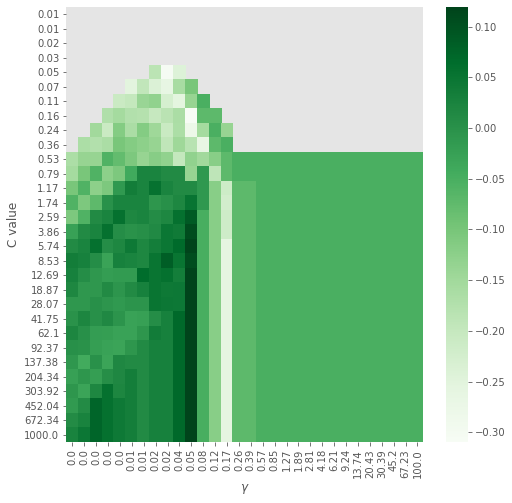

In [26]:
grid_search_SVM(features_GHDDI, features_full, active_SARS1, active_SARS2)

NER: 0.535, Sensitivity or recall: 0.111, Specificity: 0.959, Precision: 0.867, Correctly classified: 0.361, MCC: 0.112


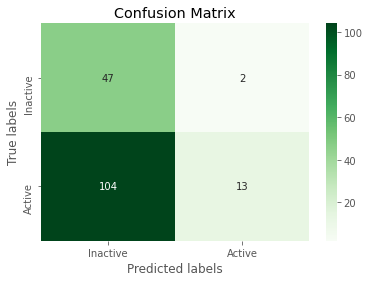

In [27]:
C= 8.53
gamm = 0.05
svm = SVC(C=C, kernel="rbf", gamma=gamm)
svm.fit(features_GHDDI, active_SARS1)
predictions = svm.predict(features_full)
vals = print_metrics(predictions, active_SARS2)
plot_confusion(predictions, active_SARS2)

Train with SARS2, test with SARS1

C=0.01, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=0.0032903445623126675


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.01, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.014873521072935119, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.022122162910704492, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.03290344562312668, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.04893900918477494, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.07278953843983153, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.10826367338740546, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.16102620275609392, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.2395026619987486, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.35622478902624444, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.529831690628371, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.7880462815669912, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.7880462815669912, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.7880462815669912, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.7880462815669912, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.7880462815669912, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.7880462815669912, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.7880462815669912, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.7880462815669912, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.7880462815669912, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.7880462815669912, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=0.7880462815669912, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.1721022975334805, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.1721022975334805, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.1721022975334805, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=0.01610262027560939
NER: 0.492, Sensitivity or recall: 0.984, Specificity: 0.000, Precision: 0.481, Correctly classified: 0.477, MCC: -0.090
C=1.1721022975334805, gamma=0.02395026619987486
NER: 0.471, Sensitivity or recall: 0.938, Specificity: 0.005, Precision: 0.470, Correctly classified: 0.457, MCC: -0.161
C=1.1721022975334805, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 0.995, Specificity: 0.005, Precision: 0.485, Correctly classified: 0.485, MCC: -0.002
C=1.1721022975334805, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC:

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.1721022975334805, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.1721022975334805, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.1721022975334805, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.1721022975334805, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.1721022975334805, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.1721022975334805, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.1721022975334805, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.743328822199989, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.743328822199989, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=0.007278953843983154
NER: 0.484, Sensitivity or recall: 0.969, Specificity: 0.000, Precision: 0.477, Correctly classified: 0.470, MCC: -0.128


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.743328822199989, gamma=0.010826367338740546
NER: 0.434, Sensitivity or recall: 0.839, Specificity: 0.029, Precision: 0.449, Correctly classified: 0.422, MCC: -0.226
C=1.743328822199989, gamma=0.01610262027560939
NER: 0.416, Sensitivity or recall: 0.793, Specificity: 0.039, Precision: 0.437, Correctly classified: 0.405, MCC: -0.258
C=1.743328822199989, gamma=0.02395026619987486
NER: 0.411, Sensitivity or recall: 0.777, Specificity: 0.044, Precision: 0.434, Correctly classified: 0.399, MCC: -0.265
C=1.743328822199989, gamma=0.03562247890262444
NER: 0.416, Sensitivity or recall: 0.813, Specificity: 0.020, Precision: 0.439, Correctly classified: 0.405, MCC: -0.278
C=1.743328822199989, gamma=0.0529831690628371
NER: 0.497, Sensitivity or recall: 0.995, Specificity: 0.000, Precision: 0.484, Correctly classified: 0.482, MCC: -0.052
C=1.743328822199989, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC:

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.743328822199989, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.743328822199989, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.743328822199989, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.743328822199989, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.743328822199989, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1.743328822199989, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1.743328822199989, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=2.592943797404667, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=2.592943797404667, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=0.004893900918477494
NER: 0.456, Sensitivity or recall: 0.907, Specificity: 0.005, Precision: 0.462, Correctly classified: 0.442, MCC: -0.207
C=2.592943797404667, gamma=0.007278953843983154
NER: 0.416, Sensitivity or recall: 0.788, Specificity: 0.044, Precision: 0.437, Correctly classified: 0.405, MCC: -0.254
C=2.592943797404667, gamma=0.010826367338740546
NER: 0.399, Sensitivity or recall: 0.731, Specificity: 0.068, Precision: 0.425, Correctly classified: 0.389, MCC: -0.270
C=2.592943797404667, gamma=0.01610262027560939
NER: 0.417, Sensitivity or recall: 0.736, Specificity: 0.098, Precision: 0.434, Correctly classified: 0.407, MCC: -0.218
C=2.592943797404667, gamma=0.02395026619987486
NER: 0.419, Sensitivity or recall: 0.741, Specificity: 0.098, Precision: 0.436, Correctly classified: 0.410, MC

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=2.592943797404667, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=2.592943797404667, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=2.592943797404667, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=2.592943797404667, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=2.592943797404667, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=2.592943797404667, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=2.592943797404667, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=3.856620421163472, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=3.856620421163472, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=3.856620421163472, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=3.856620421163472, gamma=0.0032903445623126675
NER: 0.445, Sensitivity or recall: 0.876, Specificity: 0.015, Precision: 0.456, Correctly classified: 0.432, MCC: -0.218
C=3.856620421163472, gamma=0.004893900918477494
NER: 0.405, Sensitivity or recall: 0.751, Specificity: 0.059, Precision: 0.429, Correctly classified: 0.394, MCC: -0.266
C=3.856620421163472, gamma=0.007278953843983154
NER: 0.381, Sensitivity or recall: 0.684, Specificity: 0.078, Precision: 0.411, Correctly classified: 0.372, MCC: -0.301
C=3.856620421163472, gamma=0.010826367338740546
NER: 0.406, Sensitivity or recall: 0.694, Specificity: 0.117, Precision: 0.425, Correctly classified: 0.397, MCC: -0.232
C=3.856620421163472, gamma=0.01610262027560939
NER: 0.401, Sensitivity or recall: 0.684, Specificity: 0.117, Precision: 0.422, Correctly classified: 0.392, MCC: -0.243
C=3.856620421163472, gamma=0.02395026619987486
NER: 0.414, Sensitivity or recall: 0.720, Specificity: 0.107, Precision: 0.432, Correctly classified: 0.405,

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=3.856620421163472, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=3.856620421163472, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=3.856620421163472, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=3.856620421163472, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=3.856620421163472, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=3.856620421163472, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=3.856620421163472, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=3.856620421163472, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=3.856620421163472, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=3.856620421163472, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=3.856620421163472, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=3.856620421163472, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=3.856620421163472, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=3.856620421163472, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=3.856620421163472, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=3.856620421163472, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=3.856620421163472, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=3.856620421163472, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=5.736152510448681, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=5.736152510448681, gamma=0.0014873521072935117
NER: 0.495, Sensitivity or recall: 0.990, Specificity: 0.000, Precision: 0.482, Correctly classified: 0.480, MCC: -0.073
C=5.736152510448681, gamma=0.00221221629107045
NER: 0.437, Sensitivity or recall: 0.855, Specificity: 0.020, Precision: 0.451, Correctly classified: 0.425, MCC: -0.231
C=5.736152510448681, gamma=0.0032903445623126675
NER: 0.389, Sensitivity or recall: 0.710, Specificity: 0.068, Precision: 0.418, Correctly classified: 0.379, MCC: -0.291
C=5.736152510448681, gamma=0.004893900918477494
NER: 0.373, Sensitivity or recall: 0.668, Specificity: 0.078, Precision: 0.406, Correctly classified: 0.364, MCC: -0.316
C=5.736152510448681, gamma=0.007278953843983154
NER: 0.405, Sensitivity or recall: 0.674, Specificity: 0.137, Precision: 0.423, Correctly classified: 0.397, MCC: -0.226
C=5

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=5.736152510448681, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=5.736152510448681, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=5.736152510448681, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=5.736152510448681, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=5.736152510448681, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=5.736152510448681, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=5.736152510448681, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=5.736152510448681, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=5.736152510448681, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=5.736152510448681, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=5.736152510448681, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=5.736152510448681, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=5.736152510448681, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=5.736152510448681, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=5.736152510448681, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=5.736152510448681, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=5.736152510448681, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=5.736152510448681, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=8.531678524172815, gamma=0.001
NER: 0.495, Sensitivity or recall: 0.990, Specificity: 0.000, Precision: 0.482, Correctly classified: 0.480, MCC: -0.073
C=8.531678524172815, gamma=0.0014873521072935117
NER: 0.435, Sensitivity or recall: 0.850, Specificity: 0.020, Precision: 0.449, Correctly classified: 0.422, MCC: -0.237
C=8.531678524172815, gamma=0.00221221629107045
NER: 0.379, Sensitivity or recall: 0.689, Specificity: 0.068, Precision: 0.410, Correctly classified: 0.369, MCC: -0.312
C=8.531678524172815, gamma=0.0032903445623126675
NER: 0.375, Sensitivity or recall: 0.653, Specificity: 0.098, Precision: 0.405, Correctly classified: 0.367, MCC: -0.302
C=8.531678524172815, gamma=0.004893900918477494
NER: 0.402, Sensitivity or recall: 0.663, Specificity: 0.141, Precision: 0.421, Correctly classified: 0.394, MCC: -0.230
C=8.531678524172815, gamma=0.007278953843983154
NER: 0.386, Sensitivity or recall: 0.622, Specificity: 0.151, Precision: 0.408, Correctly classified: 0.379, MCC: -0.258


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=8.531678524172815, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=8.531678524172815, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=8.531678524172815, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=8.531678524172815, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=8.531678524172815, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=8.531678524172815, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=8.531678524172815, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=8.531678524172815, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=8.531678524172815, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=8.531678524172815, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=8.531678524172815, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=8.531678524172815, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=8.531678524172815, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=8.531678524172815, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=8.531678524172815, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=8.531678524172815, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=8.531678524172815, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=8.531678524172815, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=12.689610031679234, gamma=0.001
NER: 0.434, Sensitivity or recall: 0.845, Specificity: 0.024, Precision: 0.449, Correctly classified: 0.422, MCC: -0.231
C=12.689610031679234, gamma=0.0014873521072935117
NER: 0.373, Sensitivity or recall: 0.674, Specificity: 0.073, Precision: 0.406, Correctly classified: 0.364, MCC: -0.319
C=12.689610031679234, gamma=0.00221221629107045
NER: 0.375, Sensitivity or recall: 0.653, Specificity: 0.098, Precision: 0.405, Correctly classified: 0.367, MCC: -0.302
C=12.689610031679234, gamma=0.0032903445623126675
NER: 0.392, Sensitivity or recall: 0.653, Specificity: 0.132, Precision: 0.414, Correctly classified: 0.384, MCC: -0.254
C=12.689610031679234, gamma=0.004893900918477494
NER: 0.384, Sensitivity or recall: 0.606, Specificity: 0.161, Precision: 0.405, Correctly classified: 0.377, MCC: -0.261
C=12.689610031679234, gamma=0.007278953843983154
NER: 0.393, Sensitivity or recall: 0.606, Specificity: 0.180, Precision: 0.411, Correctly classified: 0.387, MCC: -

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=12.689610031679234, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=12.689610031679234, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=12.689610031679234, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=12.689610031679234, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=12.689610031679234, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=12.689610031679234, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=12.689610031679234, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=12.689610031679234, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=12.689610031679234, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=12.689610031679234, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=12.689610031679234, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=12.689610031679234, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=12.689610031679234, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=12.689610031679234, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=12.689610031679234, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=12.689610031679234, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=12.689610031679234, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=12.689610031679234, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=18.873918221350976, gamma=0.001
NER: 0.371, Sensitivity or recall: 0.668, Specificity: 0.073, Precision: 0.404, Correctly classified: 0.362, MCC: -0.324
C=18.873918221350976, gamma=0.0014873521072935117
NER: 0.375, Sensitivity or recall: 0.653, Specificity: 0.098, Precision: 0.405, Correctly classified: 0.367, MCC: -0.302
C=18.873918221350976, gamma=0.00221221629107045
NER: 0.387, Sensitivity or recall: 0.642, Specificity: 0.132, Precision: 0.411, Correctly classified: 0.379, MCC: -0.264
C=18.873918221350976, gamma=0.0032903445623126675
NER: 0.378, Sensitivity or recall: 0.585, Specificity: 0.171, Precision: 0.399, Correctly classified: 0.372, MCC: -0.269
C=18.873918221350976, gamma=0.004893900918477494
NER: 0.383, Sensitivity or recall: 0.585, Specificity: 0.180, Precision: 0.402, Correctly classified: 0.377, MCC: -0.257
C=18.873918221350976, gamma=0.007278953843983154
NER: 0.386, Sensitivity or recall: 0.596, Specificity: 0.176, Precision: 0.405, Correctly classified: 0.379, MCC: -

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=18.873918221350976, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=18.873918221350976, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=18.873918221350976, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=18.873918221350976, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=18.873918221350976, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=18.873918221350976, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=18.873918221350976, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=18.873918221350976, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=18.873918221350976, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=18.873918221350976, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=18.873918221350976, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=18.873918221350976, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=18.873918221350976, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=18.873918221350976, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=18.873918221350976, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=18.873918221350976, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=18.873918221350976, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=18.873918221350976, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=28.072162039411786, gamma=0.001
NER: 0.375, Sensitivity or recall: 0.653, Specificity: 0.098, Precision: 0.405, Correctly classified: 0.367, MCC: -0.302
C=28.072162039411786, gamma=0.0014873521072935117
NER: 0.389, Sensitivity or recall: 0.637, Specificity: 0.141, Precision: 0.411, Correctly classified: 0.382, MCC: -0.256
C=28.072162039411786, gamma=0.00221221629107045
NER: 0.378, Sensitivity or recall: 0.585, Specificity: 0.171, Precision: 0.399, Correctly classified: 0.372, MCC: -0.269
C=28.072162039411786, gamma=0.0032903445623126675
NER: 0.383, Sensitivity or recall: 0.580, Specificity: 0.185, Precision: 0.401, Correctly classified: 0.377, MCC: -0.256
C=28.072162039411786, gamma=0.004893900918477494
NER: 0.383, Sensitivity or recall: 0.580, Specificity: 0.185, Precision: 0.401, Correctly classified: 0.377, MCC: -0.256
C=28.072162039411786, gamma=0.007278953843983154
NER: 0.386, Sensitivity or recall: 0.596, Specificity: 0.176, Precision: 0.405, Correctly classified: 0.379, MCC: -

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=28.072162039411786, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=28.072162039411786, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=28.072162039411786, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=28.072162039411786, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=28.072162039411786, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=28.072162039411786, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=28.072162039411786, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=28.072162039411786, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=28.072162039411786, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=28.072162039411786, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=28.072162039411786, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=28.072162039411786, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=28.072162039411786, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=28.072162039411786, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=28.072162039411786, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=28.072162039411786, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=28.072162039411786, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=28.072162039411786, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=41.753189365604044, gamma=0.001
NER: 0.389, Sensitivity or recall: 0.637, Specificity: 0.141, Precision: 0.411, Correctly classified: 0.382, MCC: -0.256
C=41.753189365604044, gamma=0.0014873521072935117
NER: 0.376, Sensitivity or recall: 0.580, Specificity: 0.171, Precision: 0.397, Correctly classified: 0.369, MCC: -0.274
C=41.753189365604044, gamma=0.00221221629107045
NER: 0.383, Sensitivity or recall: 0.580, Specificity: 0.185, Precision: 0.401, Correctly classified: 0.377, MCC: -0.256
C=41.753189365604044, gamma=0.0032903445623126675
NER: 0.370, Sensitivity or recall: 0.554, Specificity: 0.185, Precision: 0.391, Correctly classified: 0.364, MCC: -0.281
C=41.753189365604044, gamma=0.004893900918477494
NER: 0.383, Sensitivity or recall: 0.580, Specificity: 0.185, Precision: 0.401, Correctly classified: 0.377, MCC: -0.256
C=41.753189365604044, gamma=0.007278953843983154
NER: 0.386, Sensitivity or recall: 0.596, Specificity: 0.176, Precision: 0.405, Correctly classified: 0.379, MCC: -

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=41.753189365604044, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=41.753189365604044, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=41.753189365604044, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=41.753189365604044, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=41.753189365604044, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=41.753189365604044, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=41.753189365604044, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=41.753189365604044, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=41.753189365604044, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=41.753189365604044, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=41.753189365604044, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=41.753189365604044, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=41.753189365604044, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=41.753189365604044, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=41.753189365604044, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=41.753189365604044, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=41.753189365604044, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=41.753189365604044, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=62.10169418915616, gamma=0.001
NER: 0.378, Sensitivity or recall: 0.585, Specificity: 0.171, Precision: 0.399, Correctly classified: 0.372, MCC: -0.269
C=62.10169418915616, gamma=0.0014873521072935117
NER: 0.388, Sensitivity or recall: 0.580, Specificity: 0.195, Precision: 0.404, Correctly classified: 0.382, MCC: -0.244
C=62.10169418915616, gamma=0.00221221629107045
NER: 0.372, Sensitivity or recall: 0.554, Specificity: 0.190, Precision: 0.392, Correctly classified: 0.367, MCC: -0.275
C=62.10169418915616, gamma=0.0032903445623126675
NER: 0.372, Sensitivity or recall: 0.560, Specificity: 0.185, Precision: 0.393, Correctly classified: 0.367, MCC: -0.276
C=62.10169418915616, gamma=0.004893900918477494
NER: 0.383, Sensitivity or recall: 0.580, Specificity: 0.185, Precision: 0.401, Correctly classified: 0.377, MCC: -0.256
C=62.10169418915616, gamma=0.007278953843983154
NER: 0.386, Sensitivity or recall: 0.596, Specificity: 0.176, Precision: 0.405, Correctly classified: 0.379, MCC: -0.253


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=62.10169418915616, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=62.10169418915616, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=62.10169418915616, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=62.10169418915616, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=62.10169418915616, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=62.10169418915616, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=62.10169418915616, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=62.10169418915616, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=62.10169418915616, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=62.10169418915616, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=62.10169418915616, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=62.10169418915616, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=62.10169418915616, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=62.10169418915616, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=62.10169418915616, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=62.10169418915616, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=62.10169418915616, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=62.10169418915616, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=92.36708571873865, gamma=0.001
NER: 0.385, Sensitivity or recall: 0.575, Specificity: 0.195, Precision: 0.402, Correctly classified: 0.379, MCC: -0.249
C=92.36708571873865, gamma=0.0014873521072935117
NER: 0.377, Sensitivity or recall: 0.554, Specificity: 0.200, Precision: 0.395, Correctly classified: 0.372, MCC: -0.263
C=92.36708571873865, gamma=0.00221221629107045
NER: 0.377, Sensitivity or recall: 0.554, Specificity: 0.200, Precision: 0.395, Correctly classified: 0.372, MCC: -0.263
C=92.36708571873865, gamma=0.0032903445623126675
NER: 0.372, Sensitivity or recall: 0.560, Specificity: 0.185, Precision: 0.393, Correctly classified: 0.367, MCC: -0.276
C=92.36708571873865, gamma=0.004893900918477494
NER: 0.383, Sensitivity or recall: 0.580, Specificity: 0.185, Precision: 0.401, Correctly classified: 0.377, MCC: -0.256
C=92.36708571873865, gamma=0.007278953843983154
NER: 0.386, Sensitivity or recall: 0.596, Specificity: 0.176, Precision: 0.405, Correctly classified: 0.379, MCC: -0.253


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=92.36708571873865, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=92.36708571873865, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=92.36708571873865, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=92.36708571873865, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=92.36708571873865, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=92.36708571873865, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=92.36708571873865, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=92.36708571873865, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=92.36708571873865, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=92.36708571873865, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=92.36708571873865, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=92.36708571873865, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=92.36708571873865, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=92.36708571873865, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=92.36708571873865, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=92.36708571873865, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=92.36708571873865, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=92.36708571873865, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=137.3823795883264, gamma=0.001
NER: 0.380, Sensitivity or recall: 0.554, Specificity: 0.205, Precision: 0.396, Correctly classified: 0.374, MCC: -0.258
C=137.3823795883264, gamma=0.0014873521072935117
NER: 0.377, Sensitivity or recall: 0.544, Specificity: 0.210, Precision: 0.393, Correctly classified: 0.372, MCC: -0.262
C=137.3823795883264, gamma=0.00221221629107045
NER: 0.377, Sensitivity or recall: 0.554, Specificity: 0.200, Precision: 0.395, Correctly classified: 0.372, MCC: -0.263
C=137.3823795883264, gamma=0.0032903445623126675
NER: 0.372, Sensitivity or recall: 0.560, Specificity: 0.185, Precision: 0.393, Correctly classified: 0.367, MCC: -0.276
C=137.3823795883264, gamma=0.004893900918477494
NER: 0.383, Sensitivity or recall: 0.580, Specificity: 0.185, Precision: 0.401, Correctly classified: 0.377, MCC: -0.256
C=137.3823795883264, gamma=0.007278953843983154
NER: 0.386, Sensitivity or recall: 0.596, Specificity: 0.176, Precision: 0.405, Correctly classified: 0.379, MCC: -0.253


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=137.3823795883264, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=137.3823795883264, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=137.3823795883264, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=137.3823795883264, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=137.3823795883264, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=137.3823795883264, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=137.3823795883264, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=137.3823795883264, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=137.3823795883264, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=137.3823795883264, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=137.3823795883264, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=137.3823795883264, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=137.3823795883264, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=137.3823795883264, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=137.3823795883264, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=137.3823795883264, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=137.3823795883264, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=137.3823795883264, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=204.33597178569437, gamma=0.001
NER: 0.377, Sensitivity or recall: 0.539, Specificity: 0.215, Precision: 0.392, Correctly classified: 0.372, MCC: -0.261
C=204.33597178569437, gamma=0.0014873521072935117
NER: 0.377, Sensitivity or recall: 0.544, Specificity: 0.210, Precision: 0.393, Correctly classified: 0.372, MCC: -0.262
C=204.33597178569437, gamma=0.00221221629107045
NER: 0.377, Sensitivity or recall: 0.554, Specificity: 0.200, Precision: 0.395, Correctly classified: 0.372, MCC: -0.263
C=204.33597178569437, gamma=0.0032903445623126675
NER: 0.372, Sensitivity or recall: 0.560, Specificity: 0.185, Precision: 0.393, Correctly classified: 0.367, MCC: -0.276
C=204.33597178569437, gamma=0.004893900918477494
NER: 0.383, Sensitivity or recall: 0.580, Specificity: 0.185, Precision: 0.401, Correctly classified: 0.377, MCC: -0.256
C=204.33597178569437, gamma=0.007278953843983154
NER: 0.386, Sensitivity or recall: 0.596, Specificity: 0.176, Precision: 0.405, Correctly classified: 0.379, MCC: -

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=204.33597178569437, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=204.33597178569437, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=204.33597178569437, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=204.33597178569437, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=204.33597178569437, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=204.33597178569437, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=204.33597178569437, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=204.33597178569437, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=204.33597178569437, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=204.33597178569437, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=204.33597178569437, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=204.33597178569437, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=204.33597178569437, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=204.33597178569437, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=204.33597178569437, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=204.33597178569437, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=204.33597178569437, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=204.33597178569437, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=303.91953823132013, gamma=0.001
NER: 0.377, Sensitivity or recall: 0.539, Specificity: 0.215, Precision: 0.392, Correctly classified: 0.372, MCC: -0.261
C=303.91953823132013, gamma=0.0014873521072935117
NER: 0.377, Sensitivity or recall: 0.544, Specificity: 0.210, Precision: 0.393, Correctly classified: 0.372, MCC: -0.262
C=303.91953823132013, gamma=0.00221221629107045
NER: 0.377, Sensitivity or recall: 0.554, Specificity: 0.200, Precision: 0.395, Correctly classified: 0.372, MCC: -0.263
C=303.91953823132013, gamma=0.0032903445623126675
NER: 0.372, Sensitivity or recall: 0.560, Specificity: 0.185, Precision: 0.393, Correctly classified: 0.367, MCC: -0.276
C=303.91953823132013, gamma=0.004893900918477494
NER: 0.383, Sensitivity or recall: 0.580, Specificity: 0.185, Precision: 0.401, Correctly classified: 0.377, MCC: -0.256
C=303.91953823132013, gamma=0.007278953843983154
NER: 0.386, Sensitivity or recall: 0.596, Specificity: 0.176, Precision: 0.405, Correctly classified: 0.379, MCC: -

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=303.91953823132013, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=303.91953823132013, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=303.91953823132013, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=303.91953823132013, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=303.91953823132013, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=303.91953823132013, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=303.91953823132013, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=303.91953823132013, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=303.91953823132013, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=303.91953823132013, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=303.91953823132013, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=303.91953823132013, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=303.91953823132013, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=303.91953823132013, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=303.91953823132013, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=303.91953823132013, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=303.91953823132013, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=303.91953823132013, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=452.035365636025, gamma=0.001
NER: 0.377, Sensitivity or recall: 0.539, Specificity: 0.215, Precision: 0.392, Correctly classified: 0.372, MCC: -0.261
C=452.035365636025, gamma=0.0014873521072935117
NER: 0.377, Sensitivity or recall: 0.544, Specificity: 0.210, Precision: 0.393, Correctly classified: 0.372, MCC: -0.262
C=452.035365636025, gamma=0.00221221629107045
NER: 0.377, Sensitivity or recall: 0.554, Specificity: 0.200, Precision: 0.395, Correctly classified: 0.372, MCC: -0.263
C=452.035365636025, gamma=0.0032903445623126675
NER: 0.372, Sensitivity or recall: 0.560, Specificity: 0.185, Precision: 0.393, Correctly classified: 0.367, MCC: -0.276
C=452.035365636025, gamma=0.004893900918477494
NER: 0.383, Sensitivity or recall: 0.580, Specificity: 0.185, Precision: 0.401, Correctly classified: 0.377, MCC: -0.256
C=452.035365636025, gamma=0.007278953843983154
NER: 0.386, Sensitivity or recall: 0.596, Specificity: 0.176, Precision: 0.405, Correctly classified: 0.379, MCC: -0.253
C=452.

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=452.035365636025, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=452.035365636025, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=452.035365636025, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=452.035365636025, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=452.035365636025, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=452.035365636025, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=452.035365636025, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=452.035365636025, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=452.035365636025, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=452.035365636025, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=452.035365636025, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=452.035365636025, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=452.035365636025, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=452.035365636025, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=452.035365636025, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=452.035365636025, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=452.035365636025, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=452.035365636025, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=672.3357536499335, gamma=0.001
NER: 0.377, Sensitivity or recall: 0.539, Specificity: 0.215, Precision: 0.392, Correctly classified: 0.372, MCC: -0.261
C=672.3357536499335, gamma=0.0014873521072935117
NER: 0.377, Sensitivity or recall: 0.544, Specificity: 0.210, Precision: 0.393, Correctly classified: 0.372, MCC: -0.262
C=672.3357536499335, gamma=0.00221221629107045
NER: 0.377, Sensitivity or recall: 0.554, Specificity: 0.200, Precision: 0.395, Correctly classified: 0.372, MCC: -0.263
C=672.3357536499335, gamma=0.0032903445623126675
NER: 0.372, Sensitivity or recall: 0.560, Specificity: 0.185, Precision: 0.393, Correctly classified: 0.367, MCC: -0.276
C=672.3357536499335, gamma=0.004893900918477494
NER: 0.383, Sensitivity or recall: 0.580, Specificity: 0.185, Precision: 0.401, Correctly classified: 0.377, MCC: -0.256
C=672.3357536499335, gamma=0.007278953843983154
NER: 0.386, Sensitivity or recall: 0.596, Specificity: 0.176, Precision: 0.405, Correctly classified: 0.379, MCC: -0.253


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=672.3357536499335, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=672.3357536499335, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=672.3357536499335, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=672.3357536499335, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=672.3357536499335, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=672.3357536499335, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=672.3357536499335, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=672.3357536499335, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=672.3357536499335, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=672.3357536499335, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=672.3357536499335, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=672.3357536499335, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=672.3357536499335, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=672.3357536499335, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=672.3357536499335, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=672.3357536499335, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=672.3357536499335, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=672.3357536499335, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1000.0, gamma=0.001
NER: 0.377, Sensitivity or recall: 0.539, Specificity: 0.215, Precision: 0.392, Correctly classified: 0.372, MCC: -0.261
C=1000.0, gamma=0.0014873521072935117
NER: 0.377, Sensitivity or recall: 0.544, Specificity: 0.210, Precision: 0.393, Correctly classified: 0.372, MCC: -0.262
C=1000.0, gamma=0.00221221629107045
NER: 0.377, Sensitivity or recall: 0.554, Specificity: 0.200, Precision: 0.395, Correctly classified: 0.372, MCC: -0.263
C=1000.0, gamma=0.0032903445623126675
NER: 0.372, Sensitivity or recall: 0.560, Specificity: 0.185, Precision: 0.393, Correctly classified: 0.367, MCC: -0.276
C=1000.0, gamma=0.004893900918477494
NER: 0.383, Sensitivity or recall: 0.580, Specificity: 0.185, Precision: 0.401, Correctly classified: 0.377, MCC: -0.256
C=1000.0, gamma=0.007278953843983154
NER: 0.386, Sensitivity or recall: 0.596, Specificity: 0.176, Precision: 0.405, Correctly classified: 0.379, MCC: -0.253
C=1000.0, gamma=0.010826367338740546
NER: 0.399, Sensitivity or re

<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1000.0, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1000.0, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1000.0, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1000.0, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1000.0, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1000.0, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1000.0, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1000.0, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1000.0, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1000.0, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1000.0, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1000.0, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1000.0, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1000.0, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1000.0, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1000.0, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan
C=1000.0, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-16-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=1000.0, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.485, Correctly classified: 0.485, MCC: nan


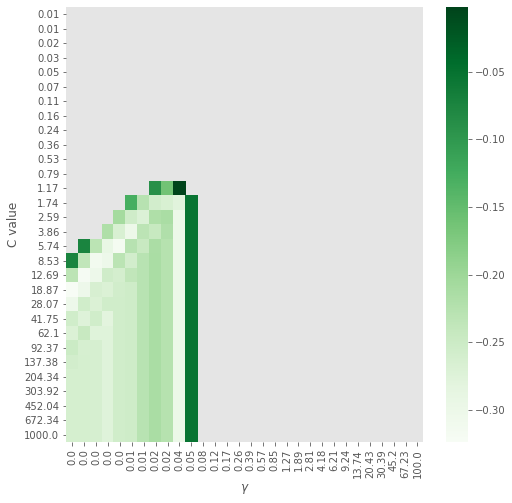

In [28]:
grid_search_SVM(features_full, features_GHDDI, active_SARS2, active_SARS1)

NER: 0.471, Sensitivity or recall: 0.938, Specificity: 0.005, Precision: 0.470, Correctly classified: 0.457, MCC: -0.161


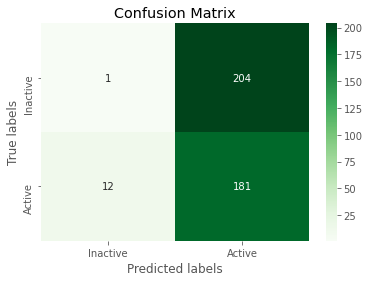

In [261]:
C= 1.172102
gamm = 0.0239
svm = SVC(C=C, kernel="rbf", gamma=gamm)
svm.fit(features_full, active_SARS2)
predictions = svm.predict(features_GHDDI)
vals = print_metrics(predictions, active_SARS1)
plot_confusion(predictions, active_SARS1)

Try 5-fold cross validation with the full data set 

In [212]:
def run_cross_validation(C, gamm, features, labels, folds=5):
    skf = StratifiedKFold(n_splits=folds)
    MCCs_train = []
    MCCs_test = []
    accs_train = []
    accs_test = []
    actives_train = []
    actives_test = []
    best_model = None
    best_model_MCC = -2
    best_model_ind = 0
    for i, (train_index, test_index) in enumerate(skf.split(features, labels)):
        train_data, test_data = features[train_index], joined_features[test_index]
        train_labels, test_labels = labels[train_index], labels[test_index]
        actives_train.append(sum(train_labels))
        actives_test.append(sum(test_labels))
        print(f"Calculating with fold {i}")
        svm = SVC(C=C, kernel="rbf", gamma=gamm)
        svm.fit(train_data, train_labels)
        pred_train = svm.predict(train_data)
        train_acc, train_mcc = print_metrics(pred_train, train_labels)
        predictions = svm.predict(test_data)
        test_acc, test_mcc = print_metrics(predictions, test_labels)
        plot_confusion(predictions, test_labels)
        if test_mcc > best_model_MCC:
            best_model = svm
            best_model_MCC = test_mcc
            best_model_ind = i
        MCCs_train.append(train_mcc)
        MCCs_test.append(test_mcc)
        accs_train.append(train_acc)
        accs_test.append(test_acc)
    print(f"Best model was obtained from fold {best_model_ind} with MCC {best_model_MCC}")
    for i, (train_index, test_index) in enumerate(skf.split(features, labels)):
        print(f"Calculating with fold {i}")
        train_data, test_data = features[train_index], joined_features[test_index]
        train_labels, test_labels = labels[train_index], labels[test_index]
        predictions = best_model.predict(test_data)
        print_metrics(predictions, test_labels)
        plot_confusion(predictions, test_labels)
    return MCCs_train, MCCs_test, accs_train, accs_test, actives_train, actives_test, best_model

def plot_results_CV(MCCs_train, MCCs_test, accs_train, accs_testm, actives_train, actives_test):
    fig, ax = plt.subplots(1,3, figsize=(14,6))
    ax[0].boxplot([accs_train, accs_test], labels=["Training", "Testing"])
    ax[1].boxplot([MCCs_train, MCCs_test], labels=["Training", "Testing"])
    ax[2].boxplot([actives_train, actives_test], labels=["Training", "Testing"])
    ax[0].set_ylabel("Accuracy")
    ax[1].set_ylabel("MCC")
    ax[2].set_ylabel("Actives proportion")

Calculating with fold 0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130]
NER: 0.893, Sensitivity or recall: 0.975, Specificity: 0.811, Precision: 0.863, Correctly classified: 0.901, MCC: 0.806
NER: 0.506, Sensitivity or recall: 0.935, Specificity: 0.077, Precision: 0.547, Correctly classified: 0.544, MCC: 0.024


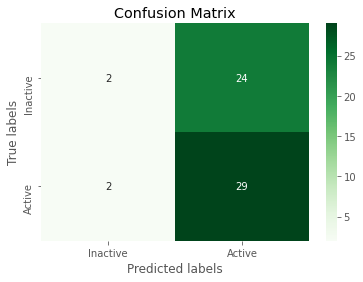

Calculating with fold 1
[ 31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48
  49  50  51  52  53  54  55  56  57  58  59  60  61 131 132 133 134 135
 136 137 138 139 140 141 153 154 155 156 157 158 159 160 161 162 163 164
 167 168 169]
NER: 0.902, Sensitivity or recall: 0.975, Specificity: 0.828, Precision: 0.874, Correctly classified: 0.909, MCC: 0.820
NER: 0.529, Sensitivity or recall: 0.903, Specificity: 0.154, Precision: 0.560, Correctly classified: 0.561, MCC: 0.087


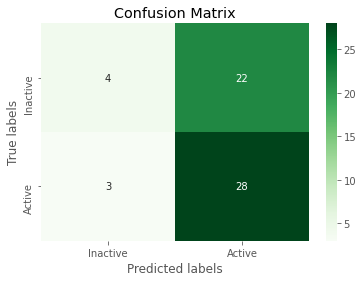

Calculating with fold 2
[ 62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92 170 173 174 175 183
 184 194 200 201 202 203 204 279 302 313 338 343 356 361 362 367 368 379
 384 385]
NER: 0.912, Sensitivity or recall: 0.986, Specificity: 0.838, Precision: 0.881, Correctly classified: 0.919, MCC: 0.842
NER: 0.719, Sensitivity or recall: 0.839, Specificity: 0.600, Precision: 0.722, Correctly classified: 0.732, MCC: 0.455


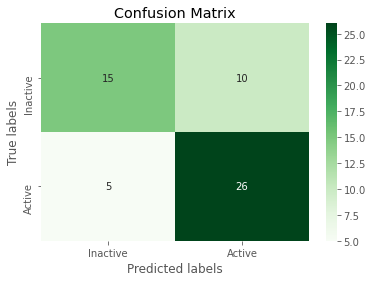

Calculating with fold 3
[ 93  94  95  96  97  98  99 100 101 102 103 104 142 143 144 145 146 147
 148 149 150 151 152 165 166 171 172 176 177 178 179 386 387 388 389 390
 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410]
NER: 0.922, Sensitivity or recall: 0.975, Specificity: 0.868, Precision: 0.900, Correctly classified: 0.927, MCC: 0.855
NER: 0.592, Sensitivity or recall: 0.903, Specificity: 0.280, Precision: 0.609, Correctly classified: 0.625, MCC: 0.238


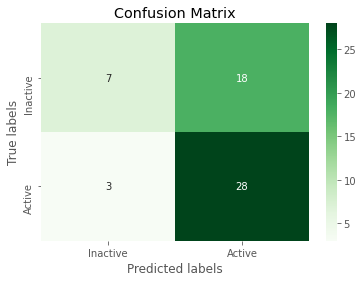

Calculating with fold 4
[180 181 182 185 186 187 188 189 190 191 192 193 195 196 197 198 199 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 411 412 413 414 415
 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433
 434 435]
NER: 0.910, Sensitivity or recall: 0.982, Specificity: 0.838, Precision: 0.881, Correctly classified: 0.917, MCC: 0.837
NER: 0.700, Sensitivity or recall: 1.000, Specificity: 0.400, Precision: 0.674, Correctly classified: 0.732, MCC: 0.519


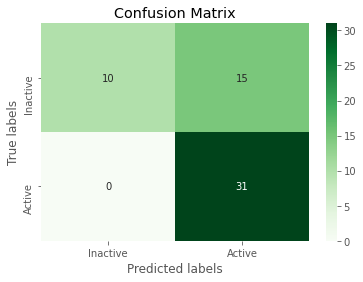

Calculating with fold 5
[219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 436 437 438 439 440
 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458
 459 460]
NER: 0.901, Sensitivity or recall: 0.978, Specificity: 0.825, Precision: 0.872, Correctly classified: 0.909, MCC: 0.822
NER: 0.692, Sensitivity or recall: 0.903, Specificity: 0.480, Precision: 0.683, Correctly classified: 0.714, MCC: 0.430


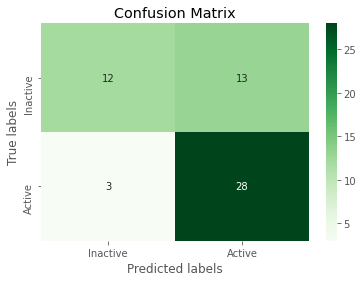

Calculating with fold 6
[250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 280 281 461 462 463 464 465
 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483
 484 485]
NER: 0.910, Sensitivity or recall: 0.982, Specificity: 0.838, Precision: 0.881, Correctly classified: 0.917, MCC: 0.837
NER: 0.820, Sensitivity or recall: 1.000, Specificity: 0.640, Precision: 0.775, Correctly classified: 0.839, MCC: 0.704


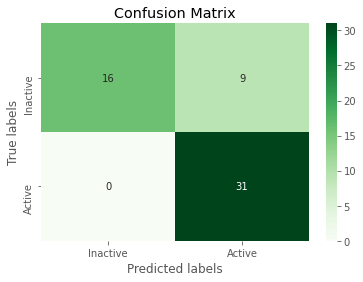

Calculating with fold 7
[282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299
 300 301 303 304 305 306 307 308 309 310 311 312 314 486 487 488 489 490
 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508
 509 510]
NER: 0.912, Sensitivity or recall: 0.982, Specificity: 0.842, Precision: 0.883, Correctly classified: 0.919, MCC: 0.841
NER: 0.848, Sensitivity or recall: 0.935, Specificity: 0.760, Precision: 0.829, Correctly classified: 0.857, MCC: 0.714


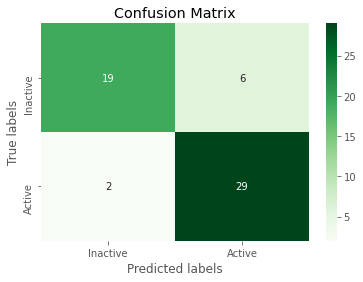

Calculating with fold 8
[315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336 337 339 340 341 342 344 345 346 347 511 512 513 514 515
 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535]
NER: 0.916, Sensitivity or recall: 0.986, Specificity: 0.846, Precision: 0.887, Correctly classified: 0.923, MCC: 0.849
NER: 0.807, Sensitivity or recall: 0.774, Specificity: 0.840, Precision: 0.857, Correctly classified: 0.804, MCC: 0.611


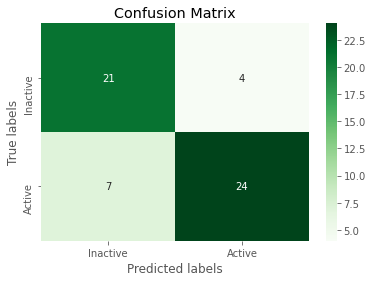

Calculating with fold 9
[348 349 350 351 352 353 354 355 357 358 359 360 363 364 365 366 369 370
 371 372 373 374 375 376 377 378 380 381 382 383 536 537 538 539 540 541
 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559
 560 561]
NER: 0.931, Sensitivity or recall: 0.986, Specificity: 0.877, Precision: 0.908, Correctly classified: 0.937, MCC: 0.875
NER: 0.864, Sensitivity or recall: 0.767, Specificity: 0.962, Precision: 0.958, Correctly classified: 0.857, MCC: 0.734


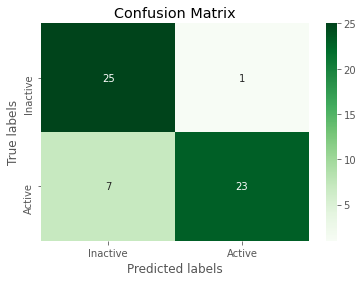

Best model was obtained from fold 9 with MCC 0.7338721796528167
Calculating with fold 0
NER: 0.923, Sensitivity or recall: 1.000, Specificity: 0.846, Precision: 0.886, Correctly classified: 0.930, MCC: 0.866


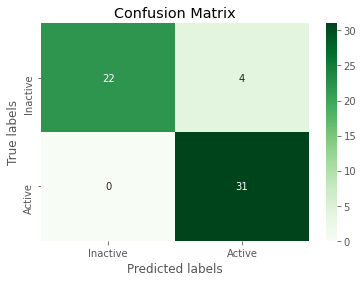

Calculating with fold 1
NER: 0.904, Sensitivity or recall: 1.000, Specificity: 0.808, Precision: 0.861, Correctly classified: 0.912, MCC: 0.834


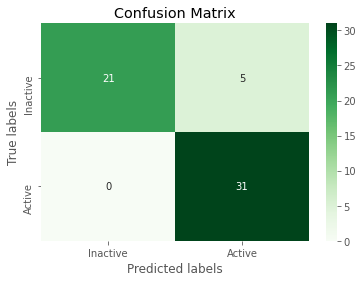

Calculating with fold 2
NER: 0.940, Sensitivity or recall: 1.000, Specificity: 0.880, Precision: 0.912, Correctly classified: 0.946, MCC: 0.896


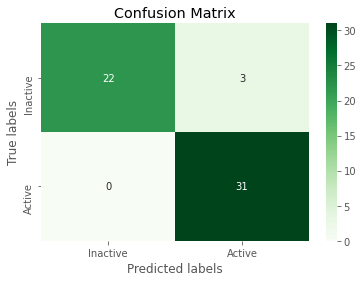

Calculating with fold 3
NER: 0.844, Sensitivity or recall: 0.968, Specificity: 0.720, Precision: 0.811, Correctly classified: 0.857, MCC: 0.722


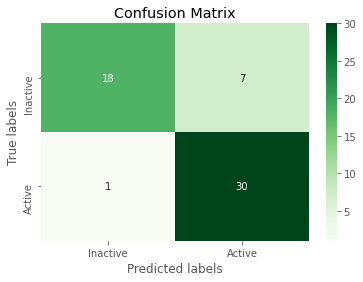

Calculating with fold 4
NER: 0.920, Sensitivity or recall: 1.000, Specificity: 0.840, Precision: 0.886, Correctly classified: 0.929, MCC: 0.863


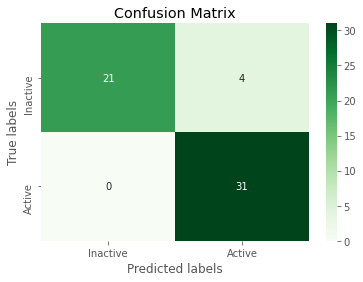

Calculating with fold 5
NER: 0.980, Sensitivity or recall: 1.000, Specificity: 0.960, Precision: 0.969, Correctly classified: 0.982, MCC: 0.964


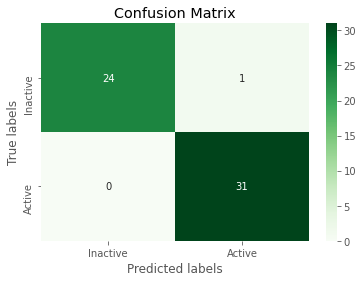

Calculating with fold 6
NER: 0.980, Sensitivity or recall: 1.000, Specificity: 0.960, Precision: 0.969, Correctly classified: 0.982, MCC: 0.964


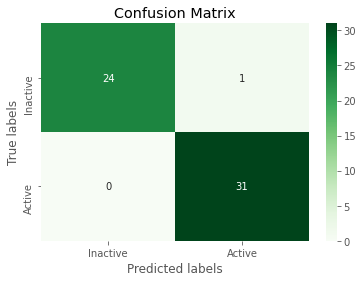

Calculating with fold 7
NER: 0.944, Sensitivity or recall: 0.968, Specificity: 0.920, Precision: 0.938, Correctly classified: 0.946, MCC: 0.892


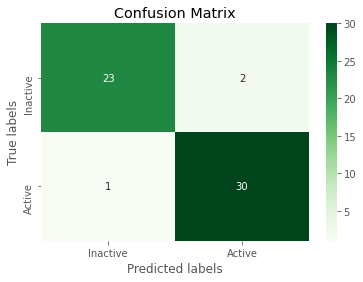

Calculating with fold 8
NER: 0.948, Sensitivity or recall: 0.935, Specificity: 0.960, Precision: 0.967, Correctly classified: 0.946, MCC: 0.893


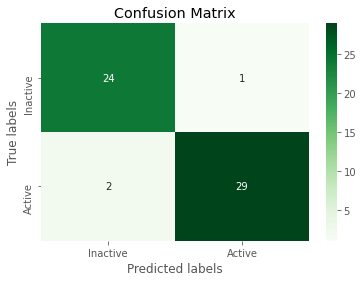

Calculating with fold 9
NER: 0.864, Sensitivity or recall: 0.767, Specificity: 0.962, Precision: 0.958, Correctly classified: 0.857, MCC: 0.734


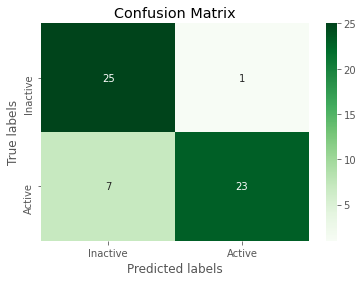

In [228]:
gamm = 0.0239502
C= 0.788046
MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all, opt_model_all = run_cross_validation(C, gamm, joined_features, active, folds=10)

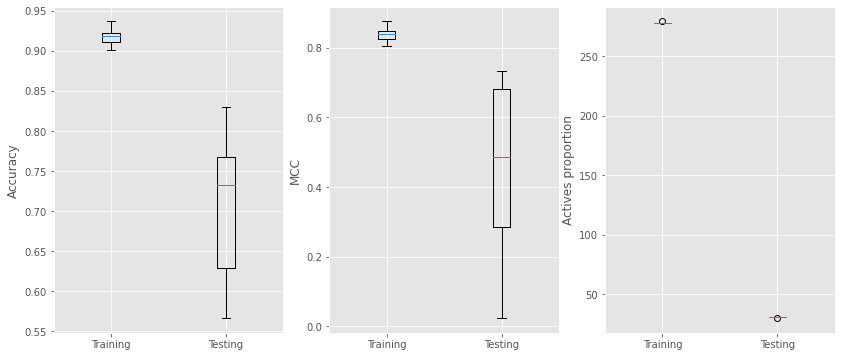

In [230]:
plot_results_CV(MCC_train_all, MCC_test_all, acc_train_all, acc_test_all, actives_train_all, actives_test_all)

NER: 0.925, Sensitivity or recall: 0.964, Specificity: 0.885, Precision: 0.911, Correctly classified: 0.929, MCC: 0.857


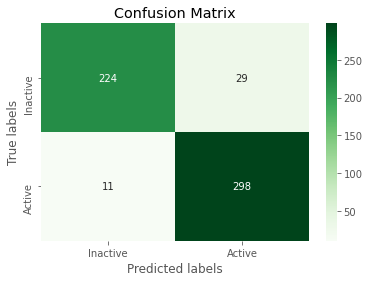

In [231]:
pred_full = opt_model_all.predict(joined_features)
print_metrics(pred_full, active)
plot_confusion(pred_full, active)

In [204]:
percentiles = list(range(1,101,5))
n_features = []
MCCs = []
accs = []
skf = StratifiedKFold(n_splits=10)
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    transform_features = feat_select.fit_transform(joined_features, active)
    n_features.append(transform_features.shape[1])
    mcc_CV = []
    acc_CV = []
    for i, (train_index, test_index) in enumerate(skf.split(transform_features, active)):
        train_data, test_data = transform_features[train_index], transform_features[test_index]
        train_labels, test_labels = active[train_index], active[test_index]
        print(f"Calculating with fold {i}, percentile {percentile}")
        svm = SVC(C=C, kernel="rbf", gamma=gamm)
        svm.fit(train_data, train_labels)
        predictions = svm.predict(test_data)
        test_acc, test_mcc = print_metrics(predictions, test_labels)
        mcc_CV.append(test_mcc)
        acc_CV.append(test_acc)
    MCCs.append(mcc_CV)
    accs.append(acc_CV)

Calculating with fold 0, percentile 1
NER: 0.452, Sensitivity or recall: 0.903, Specificity: 0.000, Precision: 0.519, Correctly classified: 0.491, MCC: -0.216
Calculating with fold 1, percentile 1
NER: 0.503, Sensitivity or recall: 0.968, Specificity: 0.038, Precision: 0.545, Correctly classified: 0.544, MCC: 0.017
Calculating with fold 2, percentile 1
NER: 0.483, Sensitivity or recall: 0.806, Specificity: 0.160, Precision: 0.543, Correctly classified: 0.518, MCC: -0.044
Calculating with fold 3, percentile 1
NER: 0.459, Sensitivity or recall: 0.839, Specificity: 0.080, Precision: 0.531, Correctly classified: 0.500, MCC: -0.122
Calculating with fold 4, percentile 1
NER: 0.580, Sensitivity or recall: 1.000, Specificity: 0.160, Precision: 0.596, Correctly classified: 0.625, MCC: 0.309
Calculating with fold 5, percentile 1
NER: 0.608, Sensitivity or recall: 0.935, Specificity: 0.280, Precision: 0.617, Correctly classified: 0.643, MCC: 0.292
Calculating with fold 6, percentile 1
NER: 0.744,

NER: 0.715, Sensitivity or recall: 0.871, Specificity: 0.560, Precision: 0.711, Correctly classified: 0.732, MCC: 0.459
Calculating with fold 5, percentile 26
NER: 0.772, Sensitivity or recall: 0.903, Specificity: 0.640, Precision: 0.757, Correctly classified: 0.786, MCC: 0.570
Calculating with fold 6, percentile 26
NER: 0.884, Sensitivity or recall: 0.968, Specificity: 0.800, Precision: 0.857, Correctly classified: 0.893, MCC: 0.788
Calculating with fold 7, percentile 26
NER: 0.875, Sensitivity or recall: 0.871, Specificity: 0.880, Precision: 0.900, Correctly classified: 0.875, MCC: 0.749
Calculating with fold 8, percentile 26
NER: 0.726, Sensitivity or recall: 0.613, Specificity: 0.840, Precision: 0.826, Correctly classified: 0.714, MCC: 0.458
Calculating with fold 9, percentile 26
NER: 0.864, Sensitivity or recall: 0.767, Specificity: 0.962, Precision: 0.958, Correctly classified: 0.857, MCC: 0.734
Calculating with fold 0, percentile 31
NER: 0.647, Sensitivity or recall: 0.871, Spec

NER: 0.888, Sensitivity or recall: 0.935, Specificity: 0.840, Precision: 0.879, Correctly classified: 0.893, MCC: 0.784
Calculating with fold 7, percentile 51
NER: 0.855, Sensitivity or recall: 0.871, Specificity: 0.840, Precision: 0.871, Correctly classified: 0.857, MCC: 0.711
Calculating with fold 8, percentile 51
NER: 0.763, Sensitivity or recall: 0.645, Specificity: 0.880, Precision: 0.870, Correctly classified: 0.750, MCC: 0.531
Calculating with fold 9, percentile 51
NER: 0.900, Sensitivity or recall: 0.800, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.893, MCC: 0.806
Calculating with fold 0, percentile 56
NER: 0.628, Sensitivity or recall: 0.871, Specificity: 0.385, Precision: 0.628, Correctly classified: 0.649, MCC: 0.296
Calculating with fold 1, percentile 56
NER: 0.628, Sensitivity or recall: 0.871, Specificity: 0.385, Precision: 0.628, Correctly classified: 0.649, MCC: 0.296
Calculating with fold 2, percentile 56
NER: 0.692, Sensitivity or recall: 0.903, Spec

NER: 0.743, Sensitivity or recall: 0.645, Specificity: 0.840, Precision: 0.833, Correctly classified: 0.732, MCC: 0.487
Calculating with fold 9, percentile 76
NER: 0.867, Sensitivity or recall: 0.733, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.857, MCC: 0.749
Calculating with fold 0, percentile 81
NER: 0.564, Sensitivity or recall: 0.935, Specificity: 0.192, Precision: 0.580, Correctly classified: 0.596, MCC: 0.194
Calculating with fold 1, percentile 81
NER: 0.557, Sensitivity or recall: 0.806, Specificity: 0.308, Precision: 0.581, Correctly classified: 0.579, MCC: 0.132
Calculating with fold 2, percentile 81
NER: 0.719, Sensitivity or recall: 0.839, Specificity: 0.600, Precision: 0.722, Correctly classified: 0.732, MCC: 0.455
Calculating with fold 3, percentile 81
NER: 0.519, Sensitivity or recall: 0.677, Specificity: 0.360, Precision: 0.568, Correctly classified: 0.536, MCC: 0.039
Calculating with fold 4, percentile 81
NER: 0.695, Sensitivity or recall: 0.871, Spec

/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


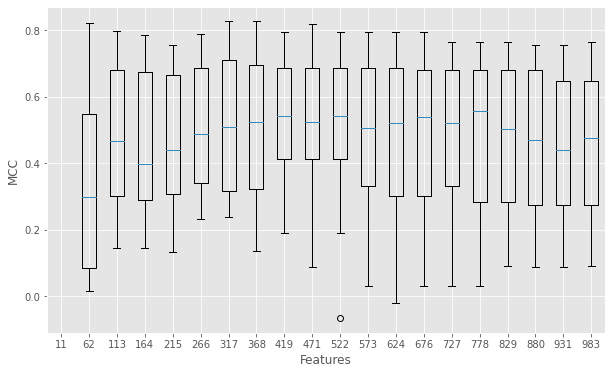

In [150]:
plt.figure(figsize=(10, 6))
plt.boxplot(MCCs, labels=n_features)
plt.ylabel("MCC")
plt.xlabel("Features");

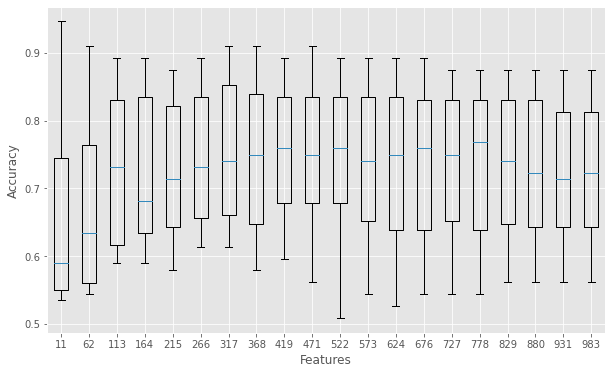

In [151]:
plt.figure(figsize=(10, 6))
plt.boxplot(accs, labels=n_features)
plt.ylabel("Accuracy")
plt.xlabel("Features");

We use now cross validation with the SARS2 set only and then use SARS1 as test set

Calculating with fold 0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23 106 107 108 109 110 111 112 113 114 115]
NER: 0.603, Sensitivity or recall: 1.000, Specificity: 0.205, Precision: 0.750, Correctly classified: 0.765, MCC: 0.392
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.706, Correctly classified: 0.706, MCC: nan


<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


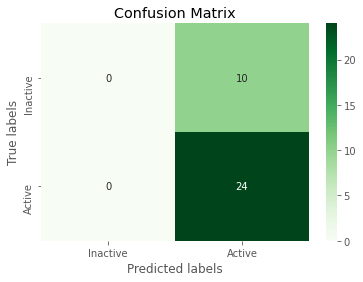

Calculating with fold 1
[ 24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47 116 117 118 119 120 121 122 123 124]
NER: 0.662, Sensitivity or recall: 1.000, Specificity: 0.325, Precision: 0.775, Correctly classified: 0.797, MCC: 0.502
NER: 0.667, Sensitivity or recall: 1.000, Specificity: 0.333, Precision: 0.800, Correctly classified: 0.818, MCC: 0.516


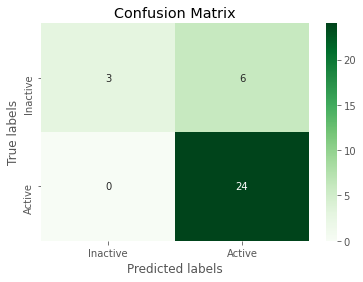

Calculating with fold 2
[ 48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70 125 126 127 128 129 130 131 132 133 134]
NER: 0.667, Sensitivity or recall: 1.000, Specificity: 0.333, Precision: 0.783, Correctly classified: 0.805, MCC: 0.511
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.697, Correctly classified: 0.697, MCC: nan


<ipython-input-80-0da7e4f1a456>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


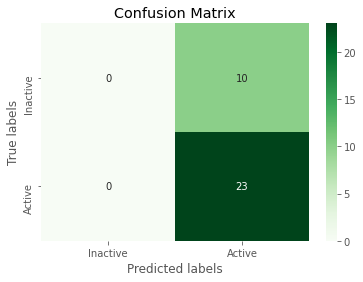

Calculating with fold 3
[ 71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93 135 136 137 138 139 140 141 142 154 155]
NER: 0.679, Sensitivity or recall: 1.000, Specificity: 0.359, Precision: 0.790, Correctly classified: 0.812, MCC: 0.533
NER: 0.550, Sensitivity or recall: 1.000, Specificity: 0.100, Precision: 0.719, Correctly classified: 0.727, MCC: 0.268


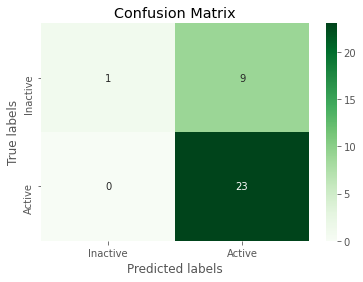

Calculating with fold 4
[ 94  95  96  97  98  99 100 101 102 103 104 105 143 144 145 146 147 148
 149 150 151 152 153 156 157 158 159 160 161 162 163 164 165]
NER: 0.628, Sensitivity or recall: 1.000, Specificity: 0.256, Precision: 0.764, Correctly classified: 0.782, MCC: 0.443
NER: 0.478, Sensitivity or recall: 0.957, Specificity: 0.000, Precision: 0.688, Correctly classified: 0.667, MCC: -0.117


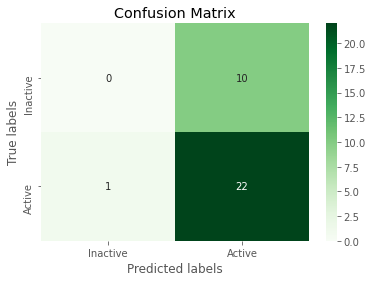

Best model was obtained from fold 1 with MCC 0.5163977794943223
Calculating with fold 0
NER: 0.700, Sensitivity or recall: 1.000, Specificity: 0.400, Precision: 0.800, Correctly classified: 0.824, MCC: 0.566


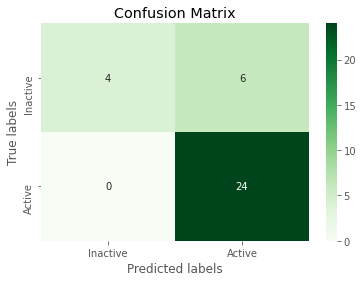

Calculating with fold 1
NER: 0.667, Sensitivity or recall: 1.000, Specificity: 0.333, Precision: 0.800, Correctly classified: 0.818, MCC: 0.516


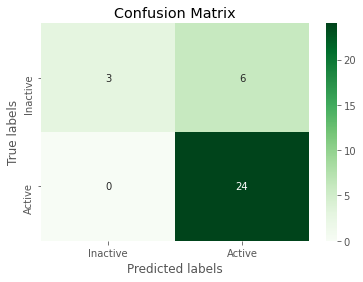

Calculating with fold 2
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.742, Correctly classified: 0.758, MCC: 0.385


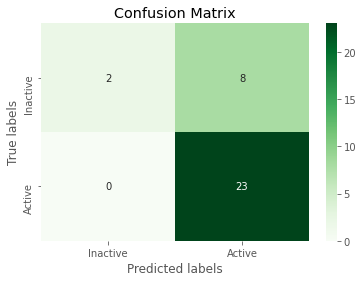

Calculating with fold 3
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.742, Correctly classified: 0.758, MCC: 0.385


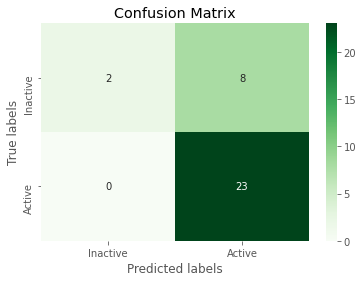

Calculating with fold 4
NER: 0.700, Sensitivity or recall: 1.000, Specificity: 0.400, Precision: 0.793, Correctly classified: 0.818, MCC: 0.563


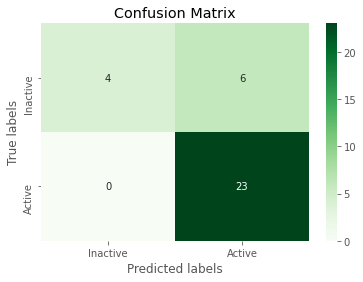

In [250]:
# features_full, features_GHDDI, active_SARS2, active_SARS1
C= 8.53167
gamm = 0.001
MCC_train12, MCC_test12, acc_train12, acc_test12, actives_train12, actives_test12, opt_model_SARS2 = run_cross_validation(C, gamm, features_full, active_SARS2, folds=5)

/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


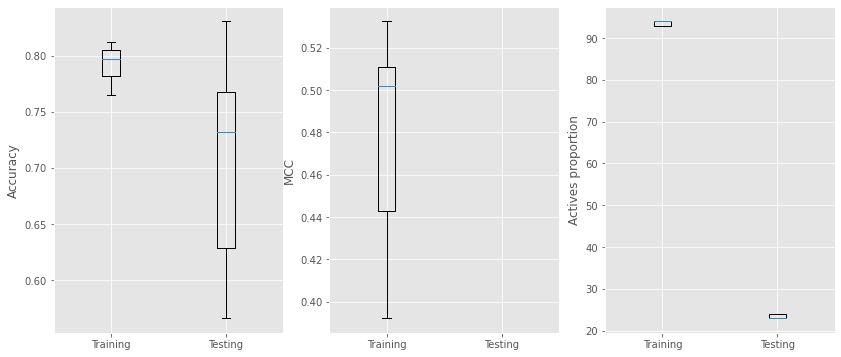

In [251]:
plot_results_CV(MCC_train12, MCC_test12, acc_train12, acc_test12, actives_train12, actives_test12)

NER: 0.492, Sensitivity or recall: 0.984, Specificity: 0.000, Precision: 0.481, Correctly classified: 0.477, MCC: -0.090


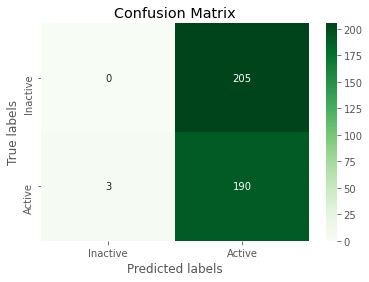

In [170]:
pred = opt_model_SARS2.predict(features_GHDDI)
print_metrics(pred, active_SARS1)
plot_confusion(pred, active_SARS1)

And use CV with SARS1 to test with SARS 2

Calculating with fold 0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  35  36  37  38  39  40
 115 138 149 174]
NER: 0.997, Sensitivity or recall: 0.994, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.997, MCC: 0.994
NER: 0.550, Sensitivity or recall: 0.200, Specificity: 0.900, Precision: 0.667, Correctly classified: 0.550, MCC: 0.140


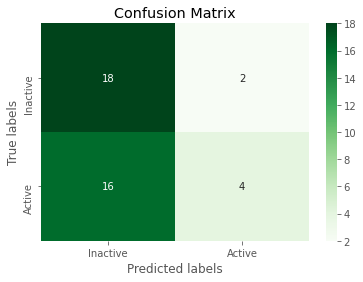

Calculating with fold 1
[ 30  31  32  33  34  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55 179 192 197 198 203 204 215 220 221 222 223 224 225 226 227 228
 229 230 231 232]
NER: 0.994, Sensitivity or recall: 0.994, Specificity: 0.995, Precision: 0.994, Correctly classified: 0.994, MCC: 0.989
NER: 0.175, Sensitivity or recall: 0.150, Specificity: 0.200, Precision: 0.158, Correctly classified: 0.175, MCC: -0.651


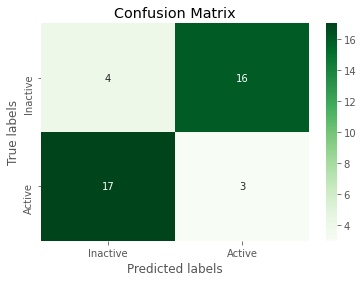

Calculating with fold 2
[ 56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248
 249 250 251 252]
NER: 0.994, Sensitivity or recall: 0.994, Specificity: 0.995, Precision: 0.994, Correctly classified: 0.994, MCC: 0.989
NER: 0.125, Sensitivity or recall: 0.250, Specificity: 0.000, Precision: 0.200, Correctly classified: 0.125, MCC: -0.775


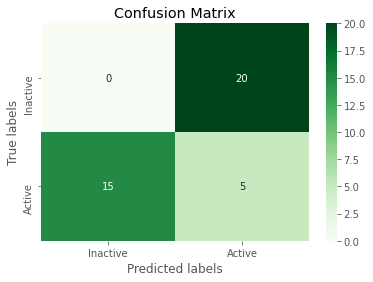

Calculating with fold 3
[ 76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273]
NER: 0.994, Sensitivity or recall: 0.994, Specificity: 0.995, Precision: 0.994, Correctly classified: 0.994, MCC: 0.989
NER: 0.076, Sensitivity or recall: 0.105, Specificity: 0.048, Precision: 0.091, Correctly classified: 0.075, MCC: -0.850


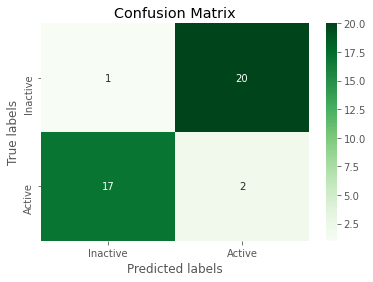

Calculating with fold 4
[ 95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290
 291 292 293 294]
NER: 0.997, Sensitivity or recall: 1.000, Specificity: 0.995, Precision: 0.994, Correctly classified: 0.997, MCC: 0.994
NER: 0.182, Sensitivity or recall: 0.316, Specificity: 0.048, Precision: 0.231, Correctly classified: 0.175, MCC: -0.666


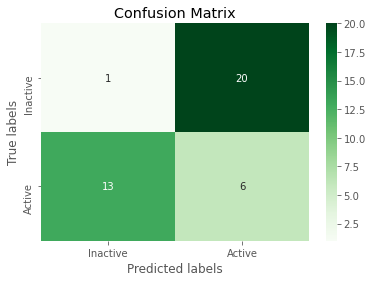

Calculating with fold 5
[114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315]
NER: 0.994, Sensitivity or recall: 0.994, Specificity: 0.995, Precision: 0.994, Correctly classified: 0.994, MCC: 0.989
NER: 0.103, Sensitivity or recall: 0.158, Specificity: 0.048, Precision: 0.130, Correctly classified: 0.100, MCC: -0.803


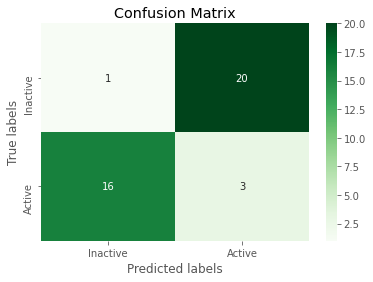

Calculating with fold 6
[134 135 136 137 139 140 141 142 143 144 145 146 147 148 150 151 152 153
 154 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336]
NER: 0.997, Sensitivity or recall: 0.994, Specificity: 1.000, Precision: 1.000, Correctly classified: 0.997, MCC: 0.994
NER: 0.000, Sensitivity or recall: 0.000, Specificity: 0.000, Precision: 0.000, Correctly classified: 0.000, MCC: -1.000


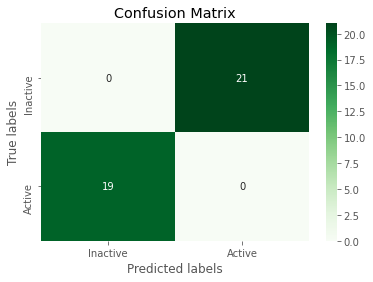

Calculating with fold 7
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353
 354 355 356 357]
NER: 0.994, Sensitivity or recall: 0.994, Specificity: 0.995, Precision: 0.994, Correctly classified: 0.994, MCC: 0.989
NER: 0.201, Sensitivity or recall: 0.211, Specificity: 0.190, Precision: 0.190, Correctly classified: 0.200, MCC: -0.599


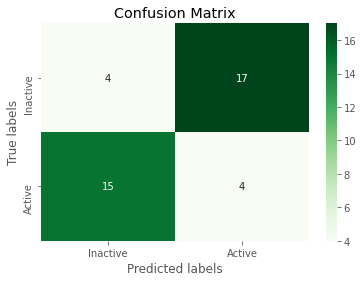

Calculating with fold 8
[175 176 177 178 180 181 182 183 184 185 186 187 188 189 190 191 193 194
 195 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374
 375 376 377]
NER: 0.994, Sensitivity or recall: 0.994, Specificity: 0.995, Precision: 0.994, Correctly classified: 0.994, MCC: 0.989
NER: 0.545, Sensitivity or recall: 0.789, Specificity: 0.300, Precision: 0.517, Correctly classified: 0.538, MCC: 0.102


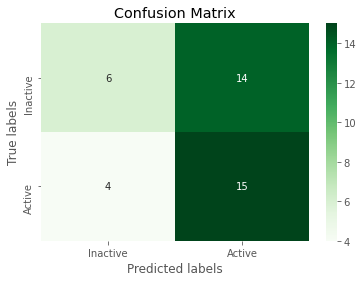

Calculating with fold 9
[196 199 200 201 202 205 206 207 208 209 210 211 212 213 214 216 217 218
 219 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394
 395 396 397]
NER: 0.997, Sensitivity or recall: 1.000, Specificity: 0.995, Precision: 0.994, Correctly classified: 0.997, MCC: 0.994
NER: 0.821, Sensitivity or recall: 0.842, Specificity: 0.800, Precision: 0.800, Correctly classified: 0.821, MCC: 0.642


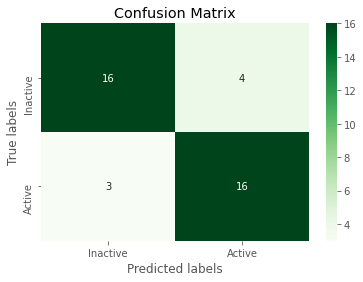

Best model was obtained from fold 9 with MCC 0.6421052631578947
Calculating with fold 0
NER: 0.500, Sensitivity or recall: 0.100, Specificity: 0.900, Precision: 0.500, Correctly classified: 0.500, MCC: 0.000


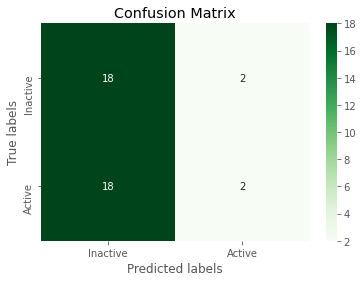

Calculating with fold 1
NER: 0.075, Sensitivity or recall: 0.050, Specificity: 0.100, Precision: 0.053, Correctly classified: 0.075, MCC: -0.851


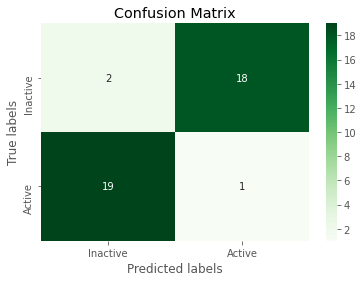

Calculating with fold 2
NER: 0.025, Sensitivity or recall: 0.050, Specificity: 0.000, Precision: 0.048, Correctly classified: 0.025, MCC: -0.951


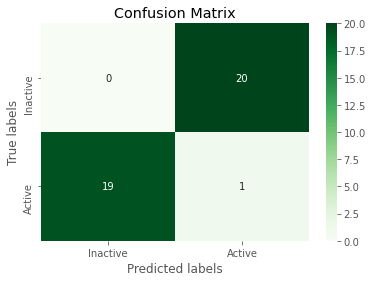

Calculating with fold 3
NER: 0.000, Sensitivity or recall: 0.000, Specificity: 0.000, Precision: 0.000, Correctly classified: 0.000, MCC: -1.000


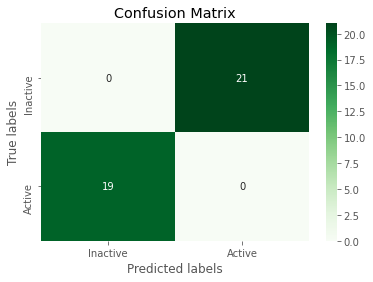

Calculating with fold 4
NER: 0.050, Sensitivity or recall: 0.053, Specificity: 0.048, Precision: 0.048, Correctly classified: 0.050, MCC: -0.900


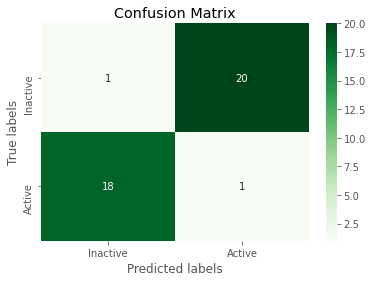

Calculating with fold 5
NER: 0.050, Sensitivity or recall: 0.053, Specificity: 0.048, Precision: 0.048, Correctly classified: 0.050, MCC: -0.900


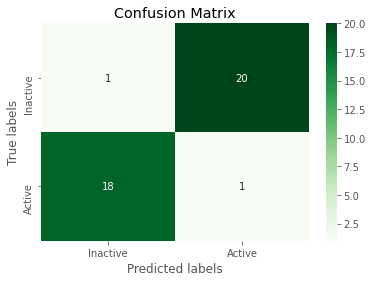

Calculating with fold 6
NER: 0.000, Sensitivity or recall: 0.000, Specificity: 0.000, Precision: 0.000, Correctly classified: 0.000, MCC: -1.000


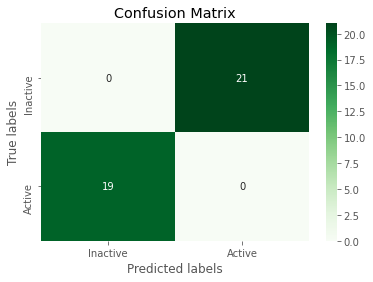

Calculating with fold 7
NER: 0.177, Sensitivity or recall: 0.211, Specificity: 0.143, Precision: 0.182, Correctly classified: 0.175, MCC: -0.649


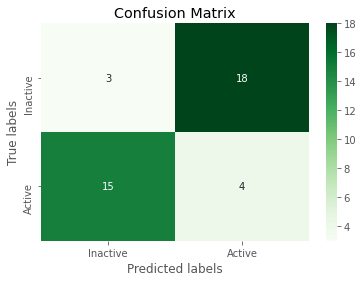

Calculating with fold 8
NER: 0.595, Sensitivity or recall: 0.789, Specificity: 0.400, Precision: 0.556, Correctly classified: 0.590, MCC: 0.205


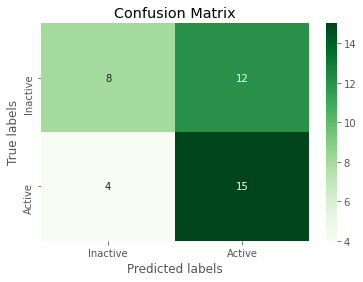

Calculating with fold 9
NER: 0.821, Sensitivity or recall: 0.842, Specificity: 0.800, Precision: 0.800, Correctly classified: 0.821, MCC: 0.642


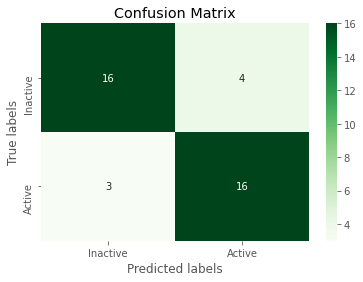

In [252]:
C= 8.53
gamm = 0.05
MCC_train12, MCC_test12, acc_train12, acc_test12, actives_train12, actives_test12, opt_model_SARS1 = run_cross_validation(C, gamm, features_GHDDI, active_SARS1, folds=10)

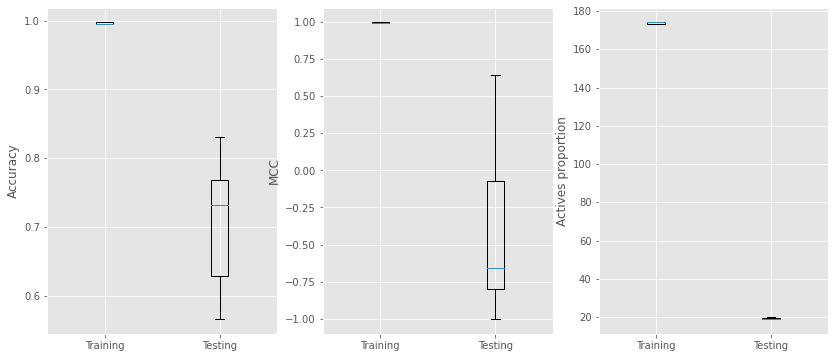

In [253]:
plot_results_CV(MCC_train12, MCC_test12, acc_train12, acc_test12, actives_train12, actives_test12)

NER: 0.520, Sensitivity or recall: 0.060, Specificity: 0.980, Precision: 0.875, Correctly classified: 0.331, MCC: 0.084


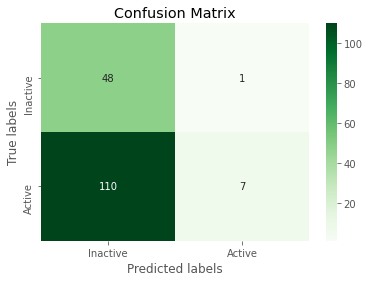

In [177]:
predictions = opt_model_SARS1.predict(features_full)
vals = print_metrics(predictions, active_SARS2)
plot_confusion(predictions, active_SARS2)

In [346]:
def calculate_distances_groups(group1, group2, aggregation_func=np.mean):
    mean = []
    for g1 in group1:
        # distances = []
        for g2 in group2:
            # distances.append(1-DataStructs.TanimotoSimilarity(g1, g2))
            if g1 == g2:
                print(g1,g2)
                continue
            mean.append(1-DataStructs.TanimotoSimilarity(g1, g2))
        # mean.append(aggregation_func(distances))
    return mean

In [347]:
mean21 = calculate_distances_groups(fps_full, fps_GHDDI)
mean12 = calculate_distances_groups(fps_GHDDI, fps_full)
mean11 = calculate_distances_groups(fps_GHDDI, fps_GHDDI)
mean22 = calculate_distances_groups(fps_full, fps_full)
meanall = calculate_distances_groups(joined_fps, joined_fps)

<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683ab5d0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354d5a8620>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354d5a8620> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683ab5d0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8d9940> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8d9940>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354cdc7800> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354cdc7800>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8bdc60> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8bdc60>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8f0990> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8f0990>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8c6ee0> <rdkit.DataStructs.cDataStructs.Explic

<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8f19e0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8f19e0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8f1ad0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8f1ad0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8f1cb0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8f1cb0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8f1e90> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8f1e90>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8dc2b0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8dc2b0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8dc3a0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8dc3a0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8dc490> <rdkit.DataStructs.cDataStructs.Explic

<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8fb350> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8fb170>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8fb350> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8fb350>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8fb440> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8fb440>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8fb440> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8fb4e0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8fb440> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8d2580>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8fb440> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8d2850>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f354c8fb530> <rdkit.DataStructs.cDataStructs.Explic

<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683c4490> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683c4490>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683c88a0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683c88a0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683b4080> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683b4080>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683c44e0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683c44e0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683b09e0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683b09e0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683b06c0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683b06c0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683d01c0> <rdkit.DataStructs.cDataStructs.Explic

<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683d2080> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683d2080>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683b08f0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683b08f0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683c4da0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683c4da0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683b4df0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683b4df0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683c0ee0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683c0ee0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683d4da0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683d4da0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35683d5210> <rdkit.DataStructs.cDataStructs.Explic

<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682aad00> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682aad00>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682aadf0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682aadf0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682aaee0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682aaee0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682a2f80> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682a2f80>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682a2f30> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682a2f30>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682a2d50> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682a2d50>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682a2990> <rdkit.DataStructs.cDataStructs.Explic

<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682c6800> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682d46c0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682c6ad0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682c6ad0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682c6cb0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682c6cb0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682c6f80> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682c6da0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682c6f80> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682c6f80>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682c8760> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682c8760>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682c8850> <rdkit.DataStructs.cDataStructs.Explic

<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682db7b0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682ce440>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682db7b0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682ce620>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682db7b0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682db6c0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682db7b0> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682db7b0>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682db990> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682db990>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682dbc60> <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682dbc60>
<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7f35682dc080> <rdkit.DataStructs.cDataStructs.Explic

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
sns.violinplot(data=[mean21, mean12], ax=axes[0])
axes[0].set(xticklabels=["SARS2 to SARS1", "SARS1 to SARS2"]);
sns.violinplot(data=[mean11, mean22], ax=axes[1])
axes[1].set(xticklabels=["SARS1 to SARS1", "SARS2 to SARS2"]);
axes[0].set_ylabel("Tanimoto distance");
sns.violinplot(data=meanall, ax=axes[2])
axes[2].set(xticklabels=["Full set"]);
min_val = 1e6
max_val = -1e6
for ax in axes:
    mini, maxi = ax.get_ylim()
    min_val = min(min_val, mini)
    max_val = max(max_val, maxi)
for ax in axes:
    ax.set_ylim(top=max_val, bottom=min_val)

In [341]:
median21 = calculate_distances_groups(fps_full, fps_GHDDI, aggregation_func=np.median)
median12 = calculate_distances_groups(fps_GHDDI, fps_full, aggregation_func=np.median)
median11 = calculate_distances_groups(fps_GHDDI, fps_GHDDI, aggregation_func=np.median)
median22 = calculate_distances_groups(fps_full, fps_full, aggregation_func=np.median)
medianall = calculate_distances_groups(joined_fps, joined_fps, aggregation_func=np.median)

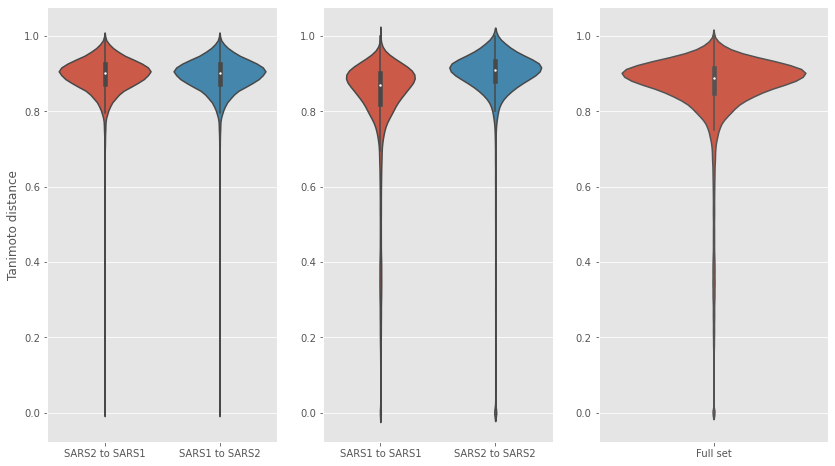

In [342]:
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
sns.violinplot(data=[median21, median12], ax=axes[0])
axes[0].set(xticklabels=["SARS2 to SARS1", "SARS1 to SARS2"]);
sns.violinplot(data=[median11, median22], ax=axes[1])
axes[1].set(xticklabels=["SARS1 to SARS1", "SARS2 to SARS2"]);
axes[0].set_ylabel("Tanimoto distance");
sns.violinplot(data=medianall, ax=axes[2])
axes[2].set(xticklabels=["Full set"]);
min_val = 1e6
max_val = -1e6
for ax in axes:
    mini, maxi = ax.get_ylim()
    min_val = min(min_val, mini)
    max_val = max(max_val, maxi)
for ax in axes:
    ax.set_ylim(top=max_val, bottom=min_val)

We examine the distance between the CV groups

In [343]:
def filter_fps(fps_list, indices):
    ind_set = set(indices)
    filtered_fps = []
    for i, fp in enumerate(fps_list):
        if i in ind_set:
            filtered_fps.append(fp)
    return filtered_fps

In [344]:
distances = []
for i, (train_index, test_index) in enumerate(skf.split(joined_features, active)):
    print(f"Calculating with fold {i}")
    train_data, test_data = filter_fps(joined_fps, train_index), filter_fps(joined_fps, test_index)
    dist = calculate_distances_groups(test_data, train_data, aggregation_func=np.median)
    distances.append(dist)

Calculating with fold 0
Calculating with fold 1
Calculating with fold 2
Calculating with fold 3
Calculating with fold 4
Calculating with fold 5
Calculating with fold 6
Calculating with fold 7
Calculating with fold 8
Calculating with fold 9


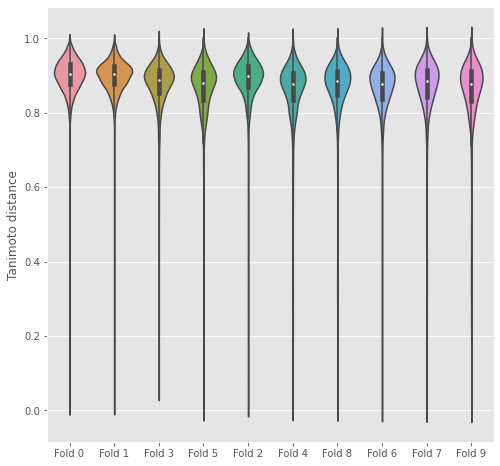

In [345]:
order = np.argsort(MCC_test_all)
distances_sorted = np.array(distances)[order]
labels = np.array([f"Fold {j}" for j in range(10)])[order]
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.violinplot(data=distances_sorted, ax=axes)
axes.set(xticklabels=labels);
axes.set_ylabel("Tanimoto distance")
plt.show()

In [289]:
selector = SelectKBest(score_func=mutual_info_classif, k='all')
selector.fit(joined_features, active)
selector_chi2 = SelectKBest(score_func=chi2, k='all')
selector_chi2.fit(joined_features, active);

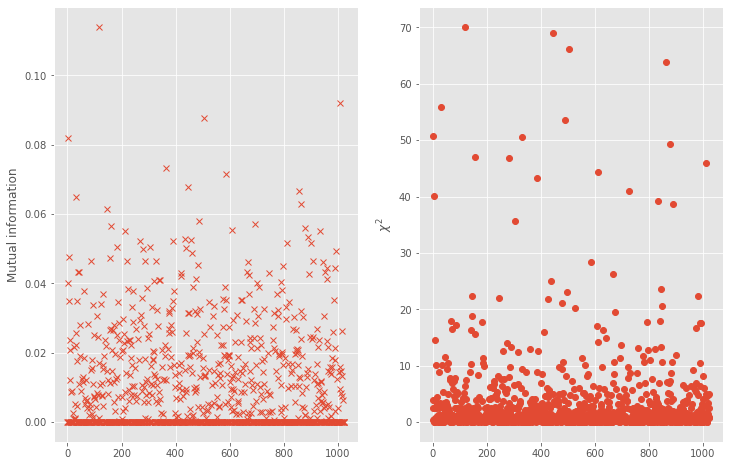

In [294]:
f, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].plot(selector.scores_, "x")
axes[0].set_ylabel("Mutual information")
axes[1].plot(selector_chi2.scores_, "o")
axes[1].set_ylabel(r"$\chi^2$");

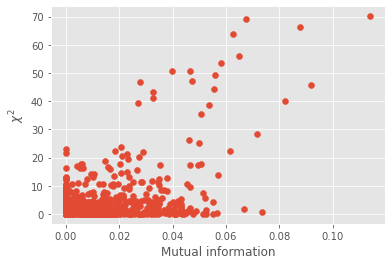

In [296]:
plt.scatter(selector.scores_, selector_chi2.scores_)
plt.xlabel("Mutual information")
plt.ylabel(r"$\chi^2$");

/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


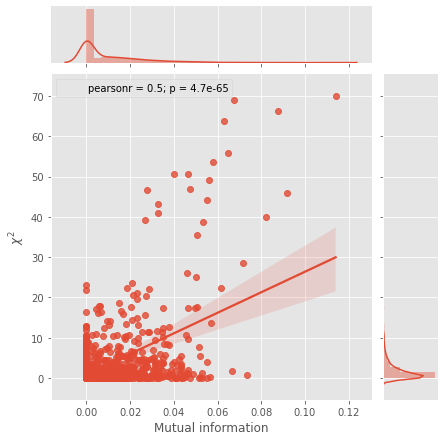

In [304]:
h = sns.jointplot(selector.scores_, selector_chi2.scores_, kind="reg")
h.set_axis_labels("Mutual information", r"$\chi^2$");
h.annotate(stats.pearsonr);

In [334]:
selector = SelectKBest(score_func=mutual_info_classif, k=20)
features_mi = selector.fit_transform(joined_features, active)
selector_chi2 = SelectKBest(score_func=chi2, k=20)
features_chi = selector_chi2.fit_transform(joined_features, active);

In [335]:
features_mi = np.hstack((features_mi, active[:, None]))
features_chi = np.hstack((features_chi, active[:, None]))

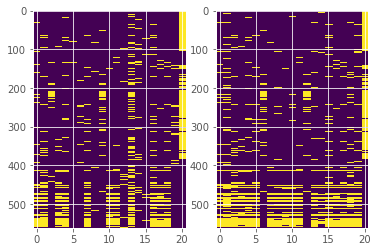

In [336]:
f, ax = plt.subplots(1, 2)
ax[0].imshow(features_mi, aspect="auto", interpolation="none")
ax[1].imshow(features_chi, aspect="auto", interpolation="none")